<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; min-width: 250px; display: flex; justify-content: center;">
        <img src="https://adnova.novaims.unl.pt/media/22ui3ptm/logo.svg" style="max-width: 80%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 3rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style='color:#6f800f'> Data Mining Project | </span>
            <span style='color:#393B79'>ABCDEats Inc.</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Fall Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Filipa Pereira, 20240509</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right,#6f800f, #393B79); 
            padding: .7px; color: white; border-radius: 300px; text-align: center;">
</div>

## 📚 Libraries Import

In [22]:
# For data
import pandas as pd
import numpy as np
import os

# For plotting and EDA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# For preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from math import ceil
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

# For PCA
from sklearn.decomposition import PCA

# Disable FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the visualization
pd.set_option('display.max_columns', None)                  # display all columns
pd.set_option('display.float_format', lambda x: '%.2f' % x) # display floats with 2 decimal places

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
plt.style.use('ggplot')
sns.set_theme(style='white')

## **Review of [`Part 1`]('./DM2425_Part1_37.ipynb')**

> Before continuing with **`Part 2`** - data preprocessing process, we believe it is important to highlight some of the changes and additions we made in Part 1, as they may be essential for this stage:

- We updated the description of the variable `is_chain` in the metadata to align with the values it takes. **<span style="color:red">querem também mudar o nome para chain_count?</span>**
- Removed 13 rows that were identified as duplicates.
- The value `'-'` in `customer_region` was replaced with `'Unknown'` to represent missing data.
- The value `'-'` in `last_promo` was considered equivalent to `'NO PROMO'`.

#### **Inconsistencies:**
- Number of cases where `vendor_count` is greater than `product_count`: 18 (0.06%).  
- Number of cases where `is_chain` is greater than `product_count`: 75 (0.24%).  
- Dropped 138 rows where the number of orders is zero.
- Number of cases where `order_count` is greater than `product_count`: 18 (0.06%), corresponding to the same cases where `vendor_count > product_count`.

#### **New Variables Created:**
- `Number of Orders`: Corresponds to the sum of the variables `DOW_0` to `DOW_6`.
- `customer_region_buckets`: Aggregated `customer_region` into buckets `2`, `4`, `8`, and `U`.
- `customer_age_group`: Age ranges grouped into buckets: `15-28`, `29-41`, `42-54`, `55-67`, `68-80`.
- `days_between_orders`: Calculated as the difference between `last_order` and `first_order`.
- `days_between_orders_per_order`: Represents the quotient between `days_between_orders` and `order_count`.
- `last_promo_bin`: Binary variable; takes the value `0` for `'NO PROMO'` and `1` otherwise.
- `CUI_Total_Amount_Spent`: Total spending across all cuisines during the study period.
- `CUI_Most_Spent_Cuisine`: Name of the cuisine where the customer spent the most money.
- `CUI_Total_Food_Types`: Count of different types of cuisines ordered.
- `CUI_Avg_Amount_Spent`: Quotient of `CUI_Total_Amount_Spent` by `order_count`.

# <a class='anchor' id='2'></a>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #6f800f,#393B79); 
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-left: 140px;margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>Part 2 | Data Preprocessing </b></h1></center>
</div>

In [23]:
# Importing the dataset
ABCDEats = pd.read_parquet('data/DM2425_ABCDEats_1stPart.parquet')

In [24]:
# Rename column 'is_chain' to 'chain_count' for better understanding
ABCDEats.rename(columns={'is_chain': 'chain_count'}, inplace=True)

In [25]:
# Display the first 5 rows just to confirm the import was successful
ABCDEats.head() 

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,chain_count,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1b8f824d5e,2360,18.00,2,5,1,0.00,1,DELIVERY,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28.88,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,2,15-28,1.00,0.50,1,28.88,Indian,1,14.44
1,5d272b9dcb,8670,17.00,2,2,2,0.00,1,DISCOUNT,DIGI,12.82,6.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,8,15-28,1.00,0.50,1,19.21,American,2,9.61
2,f6d1b2ba63,4660,38.00,1,2,2,0.00,1,DISCOUNT,CASH,9.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,4,29-41,1.00,0.50,1,9.20,American,1,4.60
3,180c632ed8,4660,NaN,2,3,1,0.00,2,DELIVERY,DIGI,0.00,13.70,0.00,0.00,0.00,0.00,0.00,0.00,17.86,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,4,None,2.00,1.00,1,31.56,Indian,2,15.78
4,4eb37a6705,4660,20.00,2,5,0,0.00,2,NO PROMO,DIGI,14.57,40.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,1,0.00,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,15-28,2.00,1.00,0,55.44,Asian,2,27.72


In [26]:
# Number of rows and columns
print('Number of\033[1m rows \033[0m:', ABCDEats.shape[0])
print('Number of\033[1m columns \033[0m:', ABCDEats.shape[1])

Number of rows : 31737
Number of columns : 66


In [27]:
# Check the data types
ABCDEats.dtypes

Variables
customer_id                object
customer_region            object
customer_age              float64
vendor_count                int64
product_count               int64
                           ...   
last_promo_bin              int64
CUI_Total_Amount_Spent    float64
CUI_Most_Spent_Cuisine     object
CUI_Total_Food_Types        int64
CUI_Avg_Amount_Spent      float64
Length: 66, dtype: object

---

# **🛠️ Data Preprocessing/Feature Engineering**

In [28]:
# Create a continuous and discrete colormap
colors = ["#3E460F", "#4E5813", "#626E18", "#7A891E", "#98AB26", "#BED62F"]
NOVAIMS_palette_colors = sns.color_palette(colors[::-1], as_cmap=True)

colors = ["#3E460F", "#4E5813", "#626E18", "#7A891E", "#98AB26", "#BED62F", "#FFFFFF"]
NOVAIMS_palette_colors_continuous = LinearSegmentedColormap.from_list("NOVAIMS_palette", colors[::-1])

In [29]:
# Define metric and non-metric features
metric_cols = ABCDEats.select_dtypes(include=['int64', 'float64']).columns.drop('last_promo_bin').to_list()
non_metric_cols = ABCDEats[:1].select_dtypes(include=['object']).columns.append(pd.Index(['last_promo_bin'])).to_list()

# Convert non_metric_cols to a pandas Index to use the drop method
non_metric_cols = pd.Index(non_metric_cols).drop('customer_id').to_list()

print(f'Metric columns: {len(metric_cols)}, {metric_cols} \n')
print(f'Non-Metric columns: {len(non_metric_cols)}, {non_metric_cols}')

Metric columns: 58, ['customer_age', 'vendor_count', 'product_count', 'chain_count', 'first_order', 'last_order', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'order_count', 'days_between_orders', 'days_between_orders_per_order', 'CUI_Total_Amount_Spent', 'CUI_Total_Food_Types', 'CUI_Avg_Amount_Spent'] 

Non-Metric columns: 7, ['customer_region', 'last_promo', 'payment_method', 'customer_region_buckets', 'customer_age_group', 'CUI_Most_Spent_Cuisine', 'last_promo_bin']


In [30]:
# Unique values of the columns 'CUI_American', 'CUI_Asian', 'CUI_Chinese', 'CUI_Italian', etc.
cuisines_cols = [col for col in ABCDEats.columns if 'CUI_' in col]
cuisines_cols

['CUI_American',
 'CUI_Asian',
 'CUI_Beverages',
 'CUI_Cafe',
 'CUI_Chicken Dishes',
 'CUI_Chinese',
 'CUI_Desserts',
 'CUI_Healthy',
 'CUI_Indian',
 'CUI_Italian',
 'CUI_Japanese',
 'CUI_Noodle Dishes',
 'CUI_OTHER',
 'CUI_Street Food / Snacks',
 'CUI_Thai',
 'CUI_Total_Amount_Spent',
 'CUI_Most_Spent_Cuisine',
 'CUI_Total_Food_Types',
 'CUI_Avg_Amount_Spent']

In [31]:
# Weeekdays columns
weekdays_cols = ABCDEats.loc[:, 'DOW_0':'DOW_6'].columns.to_list()

# Hours columns
hours_cols = ABCDEats.loc[:, 'HR_0':'HR_23'].columns.to_list()

In [32]:
# List of weekdays (0 = Sunday, 6 = Saturday)
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekdays_dict = dict(enumerate(weekdays))
weekdays_dict

{0: 'Sunday',
 1: 'Monday',
 2: 'Tuesday',
 3: 'Wednesday',
 4: 'Thursday',
 5: 'Friday',
 6: 'Saturday'}

---

In [33]:
# Convert 'last_promo_bin' to a boolean
ABCDEats['last_promo_bin'] = ABCDEats['last_promo_bin'].astype('bool')

In [34]:
# Check inconsistencies 
#    1. Number of cases where `vendor_count` is greater than `product_count`: 18 (0.06%). 
#    2. Number of cases where `chain_count` is greater than `product_count`: 75 (0.24%).  
#    3. Dropped 138 rows where the number of orders is zero.
#    4. Number of cases where `order_count` is greater than `product_count`: 18 (0.06%), corresponding to the same cases where `vendor_count > product_count`.

# 1. Number of cases where `vendor_count` is greater than `product_count`
print('Number of cases where `vendor_count` is greater than `product_count`:', ABCDEats[ABCDEats['vendor_count'] > ABCDEats['product_count']].shape[0])

# 2. Number of cases where `chain_count` is greater than `product_count`
print('Number of cases where `chain_count` is greater than `product_count`:', ABCDEats[ABCDEats['chain_count'] > ABCDEats['product_count']].shape[0])

# 3. Number of orders is zero
print('Number of rows where the number of orders is zero:', ABCDEats[ABCDEats['order_count'] == 0].shape[0])

# 4. Number of cases where `order_count` is greater than `product_count`
print('Number of cases where `order_count` is greater than `product_count`:', ABCDEats[ABCDEats['order_count'] > ABCDEats['product_count']].shape[0])

Number of cases where `vendor_count` is greater than `product_count`: 18
Number of cases where `chain_count` is greater than `product_count`: 0
Number of rows where the number of orders is zero: 0
Number of cases where `order_count` is greater than `product_count`: 18


In [35]:
# Check if cases where `vendor_count` is greater than `product_count` is the same as `order_count` is greater than `product_count`
print('Number of cases where `vendor_count` is greater than `product_count` and `order_count` is greater than `product_count`:', 
      ABCDEats[(ABCDEats['vendor_count'] > ABCDEats['product_count']) & (ABCDEats['order_count'] > ABCDEats['product_count'])].shape[0])

Number of cases where `vendor_count` is greater than `product_count` and `order_count` is greater than `product_count`: 18


In [36]:
# Check rows that have inconsistent data
# ABCDEats[(ABCDEats['vendor_count'] > ABCDEats['product_count']) & (ABCDEats['order_count'] > ABCDEats['product_count'])]

# Drop rows where `vendor_count` is greater than `product_count` is the same as `order_count` is greater than `product_count`
print(f'Number of rows before dropping: {len(ABCDEats)}')
ABCDEats = ABCDEats.drop(ABCDEats[(ABCDEats['vendor_count'] > ABCDEats['product_count']) & (ABCDEats['order_count'] > ABCDEats['product_count'])].index)
print(f'Number of rows after dropping: {len(ABCDEats)}')

Number of rows before dropping: 31737
Number of rows after dropping: 31719


---

### 🔎 **Missing Values [Imputation]** <a class='anchor' id='DP_NaNs'></a> 

In [37]:
# Check for missing values in the dataset (n = number of missing values & % = percentage of missing values)
NAs_df = pd.DataFrame({'n NAs': ABCDEats.isnull().sum(), 
                       '% NAs': round(ABCDEats.isnull().mean() * 100,2)})
NAs_df.index.name = 'Variables'

# Display the variables with missing values
NAs_df[NAs_df['n NAs'] > 0]

,n NAs,% NAs
Variables,,
customer_age,727,2.29
first_order,106,0.33
HR_0,1164,3.67
customer_age_group,727,2.29
days_between_orders,106,0.33
days_between_orders_per_order,106,0.33


#### **Approach:**

- **`first_order`**: We will impute **deterministically** as shown below.
- **`days_between_orders`**: We will impute calculating the difference between the **`first_order`** and **`last_order`** after imputation of **`first_order`**.
- **`days_between_orders_per_order`**: We will impute calculating the difference between the **`first_order`** and **`last_order`** divided by the **`total_orders`** after imputation of **`first_order`**.

<br>

- **`HR_0`**: We will impute **deterministically** knowing that:
 
 
$$ \text{Total Orders} = \sum_{i=0}^{6} \text{DOW}_i = \sum_{i=0}^{23} \text{HR}_i = \text{HR}_0 + \sum_{i=1}^{23} \text{HR}_i$$

$$ \Leftrightarrow \text{HR}_0 = \text{Total Orders} - \sum_{i=1}^{23} \text{HR}_i$$

$\qquad\qquad\qquad Where:$

$\qquad\qquad\qquad\qquad  \bullet \;\; \text{\textbf{Total Orders} is the total number of orders made by the customer.}$

$\qquad\qquad\qquad\qquad  \bullet \;\; \bf{HR_i} \; \text{is the number of orders made by the customer at hour i.}$

$\qquad\qquad\qquad\qquad  \bullet \;\; \bf{HR_0} \; \text{is the only column with missing values.}$


<br>

- **`customer_age`**: We will impute using the **KNNImputer**.
- **`customer_age_group`**: We will impute the missing values with the **`customer_age`** after imputation respective group.

In [38]:
# Check the rows with customer_age missing values
# ABCDEats[ABCDEats['customer_age'].isnull()]

In [39]:
# Check the rows with  days_between_orders and days_between_orders_per_order missing values 
ABCDEats[ABCDEats['days_between_orders'].isnull()].fillna(0).groupby('last_order')[['first_order', 'days_between_orders', 'days_between_orders_per_order']].count()

Variables,first_order,days_between_orders,days_between_orders_per_order
last_order,,,
0,106,106,106


> All cases where **`first_order`**, **`days_between_orders`** and **`days_between_orders_per_order`** are missing, have **`last_order`** equal to **$0$**.

In [40]:
ABCDEats[ABCDEats['days_between_orders'].isnull()].groupby('order_count').count()

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,chain_count,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
order_count,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,104,104,102,104,104,104,0,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,103,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,102,0,0,104,104,104,104,104
2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,2,2,2,2,2


In [41]:
# First order date -> Weekday
# Check the rows with first_order and last_order == 0/1 
ABCDEats[(ABCDEats['first_order'] == 0) & (ABCDEats['last_order'] == 1)]  # DOW_0 & DOW_6 -> Sunday & (Saturday -> First Weekday of the dataset)

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,chain_count,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1b8f824d5e,2360,18.00,2,5,1,0.00,1,DELIVERY,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28.88,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,2,15-28,1.00,0.50,True,28.88,Indian,1,14.44
1,5d272b9dcb,8670,17.00,2,2,2,0.00,1,DISCOUNT,DIGI,12.82,6.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,8,15-28,1.00,0.50,True,19.21,American,2,9.61
2,f6d1b2ba63,4660,38.00,1,2,2,0.00,1,DISCOUNT,CASH,9.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,0,0,1,0.00,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,4,29-41,1.00,0.50,True,9.20,American,1,4.60


In [42]:
# Last order date -> Weekday
# Check the rows with first and last_order == 90
ABCDEats[(ABCDEats['first_order'] == 90) & (ABCDEats['last_order'] == 90)]  # DOW_5 -> Friday

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,chain_count,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31781,d7c7face7e,2440,26.00,1,1,1,90.00,90,DELIVERY,CASH,2.61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,15-28,0.00,0.00,True,2.61,American,1,2.61


In [43]:
ABCDEats[ABCDEats['first_order'].isnull()].groupby('DOW_6').count()[['customer_id']]

Variables,customer_id
DOW_6,
1,104
2,2


#### **Imputation | `first_order`, `days_between_orders` & `days_between_orders_per_order`**:

> Deterministic imputation of **`first_order`** <br>
> Since the cases where **`first_order`** is missing, **`last_order`** is equal to **$0$**, and after check, the first weekday of the dataset is **`Saturday` $= DOW_5$**, we can conclude that the **`first_order`** of these cases is $0$.

In [44]:
# Impute the missing values in the 'first_order' column with 0
ABCDEats['first_order'] = ABCDEats['first_order'].fillna(0)

In [45]:
# Impute the missing values in the 'days_between_orders' and 'days_between_orders_per_order' knowing 'first_order'
ABCDEats['days_between_orders'] = ABCDEats['last_order'] - ABCDEats['first_order']
ABCDEats['days_between_orders_per_order'] = ABCDEats['days_between_orders'] / ABCDEats['order_count']

#### **Imputation | `HR_0`**:

> Deterministic imputation of **`HR_0`** <br>

> As we can see below (and as we already noted in **Part 1**), there are discrepancies between the total sum of **`DOW_0`** to **`DOW_6`** and the total sum of **`HR_0`** to **`HR_23`**. Moreover, there is no row where the sum of **`HR_0`** to **`HR_23`** exceeds the sum of **`DOW_0`** to **`DOW_6`**. This allows us to calculate **`HR_0`** deterministically, as previously mentioned.

In [46]:
# Through these variables we can know what number of orders are placed in total by summing all the columns 'DOW_0' to 'DOW_6' or 'HR_0' to 'HR_23'
Total_Orders_DOW = ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum().sum()

# To check if the sum of the columns 'HR_0' to 'HR_23' is equal to the total number of orders
Total_Orders_HR = ABCDEats.loc[:, 'HR_0':'HR_23'].sum().sum()
print("Sum of the columns 'DOW_0' to 'DOW_6':",Total_Orders_DOW)
print("Sum of the columns 'HR_0' to 'HR_23':",Total_Orders_HR)

# Difference between the sum of the columns 'HR_0' to 'HR_23' and the sum of the columns 'DOW_0' to 'DOW_6'
print("The difference is:",Total_Orders_HR - Total_Orders_DOW)

Sum of the columns 'DOW_0' to 'DOW_6': 139245
Sum of the columns 'HR_0' to 'HR_23': 137693.0
The difference is: -1552.0


In [47]:
# Check number of cases that sum of DOW_0 to DOW_6 is less than sum of HR_0 to HR_23
print(f"Number of cases where sum of DOW_0 to DOW_6 is less than sum of HR_0 to HR_23: ",
      f"{(ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) < ABCDEats.loc[:, 'HR_0':'HR_23'].sum(axis=1)).sum()}",
      f"({(ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) < ABCDEats.loc[:, 'HR_0':'HR_23'].sum(axis=1)).sum()/len(ABCDEats) * 100:.2f}%)")

Number of cases where sum of DOW_0 to DOW_6 is less than sum of HR_0 to HR_23:  0 (0.00%)


In [48]:
# Impute the missing values in the 'HR_0' column with sum(DOW_0:DOW_6) - sum(HR_1:HR_23)
ABCDEats['HR_0'] = ABCDEats['HR_0'].fillna(ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) - ABCDEats.loc[:, 'HR_1':'HR_23'].sum(axis=1))
ABCDEats['HR_0'] = ABCDEats['HR_0'].astype(int)

In [49]:
# Absolute and Relative Frequency Table of the column `HR_0` after imputation
HR_0_n_freq = ABCDEats['HR_0'].value_counts().reset_index()
HR_0_n_freq.columns = ['HR_0', 'n']
HR_0_n_freq['%'] = round(HR_0_n_freq['n'] / ABCDEats.shape[0] * 100, 2)
HR_0_n_freq.set_index('HR_0', inplace=True)
pd.DataFrame(HR_0_n_freq.sort_values(by='n', ascending=False))

,n,%
HR_0,,
0,30555,96.33
1,934,2.94
2,159,0.50
3,39,0.12
4,15,0.05
5,8,0.03
9,2,0.01
6,2,0.01
12,1,0.00


In [50]:
# Check if the sum of the columns 'DOW_0':'DOW_6' is equal to the sum of the columns 'HR_0':'HR_23'
ABCDEats.loc[:, 'DOW_0':'DOW_6'].sum().sum() == ABCDEats.loc[:, 'HR_0':'HR_23'].sum().sum()

True

#### **Imputation | `customer_age` & `customer_age_group`**:

> Imputation of **`customer_age`** using the **KNNImputer** <br>

In [51]:
# Impute the missing values in the 'customer_age' column with KNNImputer
ABCDEats_neighbors = ABCDEats.copy()

# Seeing rows with NaNs
nans_index = ABCDEats.isna().any(axis=1)
ABCDEats[nans_index]

Variables,customer_id,customer_region,customer_age,vendor_count,product_count,chain_count,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,180c632ed8,4660,NaN,2,3,1,0.00,2,DELIVERY,DIGI,0.00,13.70,0.00,0.00,0.00,0.00,0.00,0.00,17.86,0.00,0.00,0.00,0.00,0.00,0.00,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,4,None,2.00,1.00,True,31.56,Indian,2,15.78
27,8e8652bdc8,4660,NaN,2,3,2,0.00,6,DISCOUNT,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.88,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,4,None,6.00,3.00,True,34.88,Indian,1,17.44
37,6137fa5620,8670,NaN,2,2,2,0.00,8,DISCOUNT,CARD,6.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.15,0.00,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,8,None,8.00,4.00,True,19.28,Street Food / Snacks,2,9.64
69,2a90e9da84,4660,NaN,2,2,1,0.00,17,NO PROMO,CARD,15.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.54,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,2,4,None,17.00,8.50,False,17.53,American,2,8.77
73,a67d3108cb,8670,NaN,2,2,1,0.00,17,NO PROMO,CARD,0.00,25.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,None,17.00,8.50,False,25.85,Asian,1,12.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31488,46aa9dfeb0,8670,NaN,1,2,0,87.00,87,DELIVERY,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,25.05,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,8,None,0.00,0.00,True,25.05,Street Food / Snacks,1,25.05
31572,29207a92c8,2360,NaN,1,1,1,88.00,88,NO PROMO,CASH,0.00,0.00,3.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,None,0.00,0.00,False,3.88,Beverages,1,3.88
31762,d7bf721199,2360,NaN,1,1,1,89.00,89,NO PROMO,DIGI,0.00,0.00,0.00,0.00,0.00,0.00,3.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,None,0.00,0.00,False,3.74,Desserts,1,3.74


In [52]:
# Firstly, we need to scale the data before using the KNNImputer
scaler = StandardScaler()
ABCDEats_neighbors[metric_cols] = scaler.fit_transform(ABCDEats_neighbors[metric_cols])

# KNNImputer - only works for numerical variables. Fill NaNs on ABCDEats['customer_age'] 
imputer = KNNImputer(n_neighbors=5, weights="uniform")
ABCDEats_neighbors[metric_cols] = imputer.fit_transform(ABCDEats_neighbors[metric_cols])

In [53]:
# See rows with NaNs imputed
ABCDEats_neighbors.loc[nans_index, metric_cols]

Variables,customer_age,vendor_count,product_count,chain_count,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-0.52,-0.40,-0.39,-0.46,-1.17,-2.67,-0.42,0.16,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,2.17,-0.29,-0.30,-0.16,-0.31,-0.25,-0.19,-0.55,0.41,-0.57,-0.58,-0.62,-0.61,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,0.64,-0.37,-0.37,1.30,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.47,-1.14,-0.95,-0.15,-0.19,0.70
27,-0.71,-0.40,-0.39,-0.21,-1.17,-2.49,-0.42,-0.42,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,4.46,-0.29,-0.30,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,-0.57,-0.58,-0.62,0.32,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.40,-0.37,-0.37,-0.36,2.33,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.47,-1.00,-0.69,-0.08,-0.87,0.91
37,-0.02,-0.40,-0.53,-0.21,-1.17,-2.41,0.11,-0.42,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.29,-0.30,-0.16,-0.31,0.59,-0.19,0.43,-0.55,-0.57,-0.58,-0.62,-0.61,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,2.82,-0.20,-0.21,-0.32,-0.37,-0.40,-0.37,-0.37,1.30,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.47,-0.93,-0.57,-0.41,-0.19,-0.08
69,0.91,-0.40,-0.53,-0.46,-1.17,-2.02,0.95,-0.42,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.15,-0.30,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,0.39,-0.58,-0.62,-0.61,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.40,-0.37,-0.37,-0.36,0.98,-0.41,-0.42,-0.38,0.94,-0.24,-0.20,-0.16,-0.16,-0.47,-0.63,0.00,-0.45,-0.19,-0.20
73,-0.55,-0.40,-0.53,-0.46,-1.17,-2.02,-0.42,0.67,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.29,-0.30,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,0.39,-0.58,-0.62,-0.61,0.25,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,1.36,1.05,-0.37,-0.40,-0.37,-0.37,-0.36,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.47,-0.63,0.00,-0.27,-0.87,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31488,-0.24,-0.76,-0.53,-0.71,2.44,1.00,-0.42,-0.42,-0.27,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.29,-0.30,-0.16,-0.31,1.36,-0.19,-0.55,-0.55,0.39,-0.58,-0.62,-0.61,-0.61,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.40,0.81,-0.37,-0.36,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.67,-1.21,-1.08,-0.29,-0.87,1.88
31572,0.35,-0.76,-0.67,-0.46,2.48,1.05,-0.42,-0.42,0.18,-0.12,-0.21,-0.18,-0.17,-0.16,-0.22,-0.29,-0.30,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,-0.57,0.35,-0.62,-0.61,-0.61,-0.16,2.98,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.40,-0.37,-0.37,-0.36,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.67,-1.21,-1.08,-0.74,-0.87,-0.82
31762,-0.21,-0.76,-0.67,-0.46,2.52,1.09,-0.42,-0.42,-0.27,-0.12,-0.21,-0.18,0.54,-0.16,-0.22,-0.29,-0.30,-0.16,-0.31,-0.25,-0.19,-0.55,-0.55,-0.57,-0.58,0.29,-0.61,-0.61,-0.16,-0.17,-0.18,-0.24,-0.23,-0.23,-0.21,-0.20,-0.21,-0.32,-0.37,-0.40,-0.37,-0.37,1.30,-0.38,-0.41,-0.42,-0.38,-0.31,-0.24,-0.20,-0.16,-0.16,-0.67,-1.21,-1.08,-0.75,-0.87,-0.84


In [54]:
# Inverse the scaling
ABCDEats_neighbors[metric_cols] = scaler.inverse_transform(ABCDEats_neighbors[metric_cols])

In [55]:
# Compare the imputed values with the original values
comparison = pd.concat([ABCDEats.loc[nans_index, metric_cols], ABCDEats_neighbors.loc[nans_index, metric_cols]], axis=1, keys=['Original', 'Imputed'])

# Show the comparison between the original and imputed values sorted column names
columns_interleaved = [col for metric in metric_cols for col in [('Original', metric), ('Imputed', metric)]]
comparison[columns_interleaved]

,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed,Original,Imputed
Variables,customer_age,customer_age,vendor_count,vendor_count,product_count,product_count,chain_count,chain_count,first_order,first_order,last_order,last_order,CUI_American,CUI_American,CUI_Asian,CUI_Asian,CUI_Beverages,CUI_Beverages,CUI_Cafe,CUI_Cafe,CUI_Chicken Dishes,CUI_Chicken Dishes,CUI_Chinese,CUI_Chinese,CUI_Desserts,CUI_Desserts,CUI_Healthy,CUI_Healthy,CUI_Indian,CUI_Indian,CUI_Italian,CUI_Italian,CUI_Japanese,CUI_Japanese,CUI_Noodle Dishes,CUI_Noodle Dishes,CUI_OTHER,CUI_OTHER,CUI_Street Food / Snacks,CUI_Street Food / Snacks,CUI_Thai,CUI_Thai,DOW_0,DOW_0,DOW_1,DOW_1,DOW_2,DOW_2,DOW_3,DOW_3,DOW_4,DOW_4,DOW_5,DOW_5,DOW_6,DOW_6,HR_0,HR_0,HR_1,HR_1,HR_2,HR_2,HR_3,HR_3,HR_4,HR_4,HR_5,HR_5,HR_6,HR_6,HR_7,HR_7,HR_8,HR_8,HR_9,HR_9,HR_10,HR_10,HR_11,HR_11,HR_12,HR_12,HR_13,HR_13,HR_14,HR_14,HR_15,HR_15,HR_16,HR_16,HR_17,HR_17,HR_18,HR_18,HR_19,HR_19,HR_20,HR_20,HR_21,HR_21,HR_22,HR_22,HR_23,HR_23,order_count,order_count,days_between_orders,days_between_orders,days_between_orders_per_order,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Total_Food_Types,CUI_Avg_Amount_Spent,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,23.80,2,2.00,3,3.00,1,1.00,0.00,-0.00,2,2.00,0.00,0.00,13.70,13.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.86,17.86,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,0,0.00,0,0.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,2,2.00,2.00,2.00,1.00,1.00,31.56,31.56,2,2.00,15.78,15.78
27,NaN,22.40,2,2.00,3,3.00,2,2.00,0.00,-0.00,6,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.88,34.88,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,2,2.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,2,2.00,6.00,6.00,3.00,3.00,34.88,34.88,1,1.00,17.44,17.44
37,NaN,27.40,2,2.00,2,2.00,2,2.00,0.00,-0.00,8,8.00,6.13,6.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,13.15,13.15,0.00,0.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00,2,2.00,8.00,8.00,4.00,4.00,19.28,19.28,2,2.00,9.64,9.64
69,NaN,34.00,2,2.00,2,2.00,1,1.00,0.00,-0.00,17,17.00,15.99,15.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.54,1.54,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0.00,1,1.00,0,0.00,0,0.00,0,0.00,1,1.00,0,0.00,0,0.00,0,0.00,0,0.00,0,

In [56]:
# The age of a person is an integer number and KNNImputer returns a float in certain cases

# Round the 'customer_age' column
ABCDEats_neighbors['customer_age'] = ABCDEats_neighbors['customer_age'].round()

In [57]:
# See rows with NaNs imputed
ABCDEats_neighbors.loc[nans_index, metric_cols]

Variables,customer_age,vendor_count,product_count,chain_count,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,24.00,2.00,3.00,1.00,-0.00,2.00,0.00,13.70,0.00,0.00,0.00,0.00,0.00,0.00,17.86,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2.00,1.00,31.56,2.00,15.78
27,22.00,2.00,3.00,2.00,-0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.88,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,6.00,3.00,34.88,1.00,17.44
37,27.00,2.00,2.00,2.00,-0.00,8.00,6.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,13.15,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,8.00,4.00,19.28,2.00,9.64
69,34.00,2.00,2.00,1.00,-0.00,17.00,15.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.54,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,2.00,17.00,8.50,17.53,2.00,8.77
73,24.00,2.00,2.00,1.00,-0.00,17.00,0.00,25.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,17.00,8.50,25.85,1.00,12.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31488,26.00,1.00,2.00,0.00,87.00,87.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,25.05,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,25.05,1.00,25.05
31572,30.00,1.00,1.00,1.00,88.00,88.00,0.00,0.00,3.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3.88,1.00,3.88
31762,26.00,1.00,1.00,1.00,89.00,89.00,0.00,0.00,0.00,0.00,0.00,0.00,3.74,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3.74,1.00,3.74


In [58]:
# Check for missing values in the dataset (n = number of missing values & % = percentage of missing values)
NAs_df_neighbors = pd.DataFrame({'n NAs': ABCDEats_neighbors.isnull().sum(),
                                 '% NAs': round(ABCDEats_neighbors.isnull().mean() * 100,2)})
NAs_df_neighbors.index.name = 'Variables'
NAs_df_neighbors[NAs_df_neighbors['n NAs'] > 0]

,n NAs,% NAs
Variables,,
customer_age_group,727,2.29


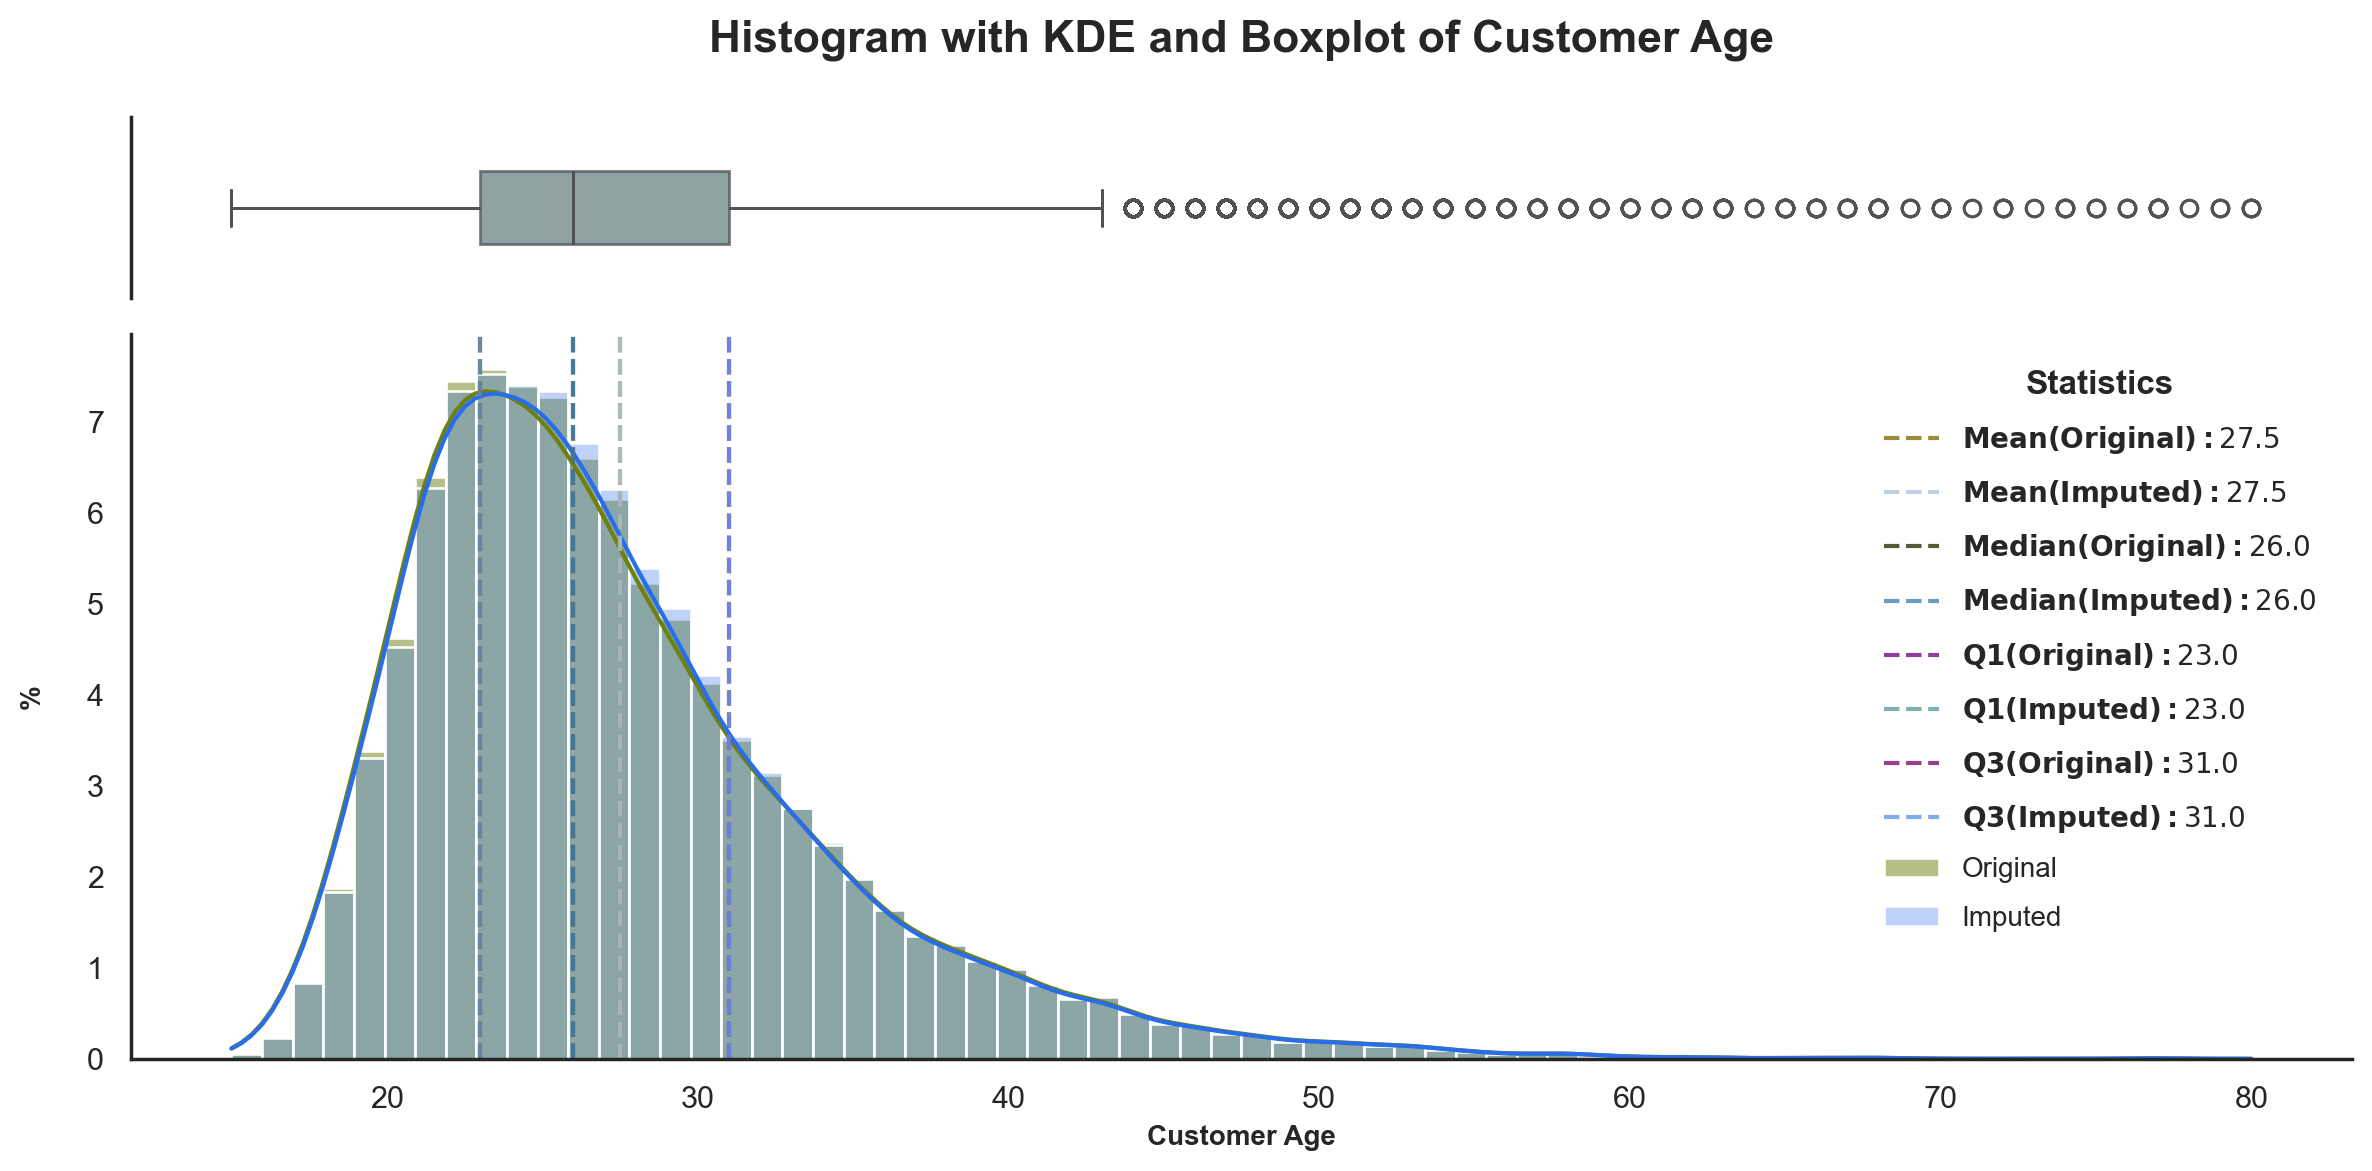

In [59]:
# Histogram of the column 'customer_age' with Kernel Density Estimate (KDE) and BoxPlot on top of the histogram [Before & After Imputation]

# Create a plot with 2 axes (one for the histogram and one for the boxplot)
fig, (ax_box, ax_hist) = plt.subplots(2,                                               # 2 rows
                                      sharex=True,                                     # Share the x-axis
                                      gridspec_kw={"height_ratios": (.20, .80)},       # Set the height ratios
                                      figsize=(12, 6))                                 # Set the figure size

# Plot the Boxplot on the top
sns.boxplot(ABCDEats['customer_age'], color='#6f800f', orient='h', ax=ax_box, width=0.4, boxprops=dict(alpha=.5))
sns.boxplot(ABCDEats_neighbors['customer_age'], color='#286dec', orient='h', ax=ax_box, width=0.4, boxprops=dict(alpha=.3))

# Plot the Histogram and the KDE on the bottom
sns.histplot(ABCDEats['customer_age'], bins=ABCDEats['customer_age'].nunique(), color='#6f800f', alpha=0.5, stat='percent', kde=True, ax=ax_hist, label='Original')
sns.histplot(ABCDEats_neighbors['customer_age'], bins=ABCDEats_neighbors['customer_age'].nunique(), color='#286dec', alpha=0.3, stat='percent', kde=True, ax=ax_hist, label='Imputed')

# Add title and labels
ax_box.set_title('Histogram with KDE and Boxplot of Customer Age\n', fontweight='bold', fontsize=16)
ax_box.set(xlabel='')
ax_hist.set_xlabel('Customer Age', fontweight='bold', fontsize=10)
ax_hist.set_ylabel('%\n', fontweight='bold', fontsize=10)

# Add mean, median and percentiles to the plot
mean_age = ABCDEats['customer_age'].mean()
median_age = ABCDEats['customer_age'].median()
q1_age = ABCDEats['customer_age'].quantile(0.25)
q3_age = ABCDEats['customer_age'].quantile(0.75)

mean_age_neighbors = ABCDEats_neighbors['customer_age'].mean()
median_age_neighbors = ABCDEats_neighbors['customer_age'].median()
q1_age_neighbors = ABCDEats_neighbors['customer_age'].quantile(0.25)
q3_age_neighbors = ABCDEats_neighbors['customer_age'].quantile(0.75)

plt.axvline(mean_age, color='#806F0F', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Mean (Original):}} {mean_age:.1f}$')
plt.axvline(mean_age_neighbors, color='#B0C4DE', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Mean (Imputed):}} {mean_age_neighbors:.1f}$')
plt.axvline(median_age, color='#2A3006', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Median (Original):}} {median_age:.1f}$')
plt.axvline(median_age_neighbors, color='#4682B4', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Median (Imputed):}} {median_age_neighbors:.1f}$')
plt.axvline(q1_age, color='#6F0F80', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Q1 (Original):}} {q1_age:.1f}$')
plt.axvline(q1_age_neighbors, color='#5F9EA0', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Q1 (Imputed):}} {q1_age_neighbors:.1f}$')
plt.axvline(q3_age, color='#800F6F', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Q3 (Original):}} {q3_age:.1f}$')
plt.axvline(q3_age_neighbors, color='#6495ED', linestyle='--', linewidth=1.5, alpha=0.8, label=rf'$\mathbf{{Q3 (Imputed):}} {q3_age_neighbors:.1f}$')

plt.legend(fontsize=10, title='Statistics', title_fontproperties={'weight':'bold', 'size':'12'},
           labelspacing=0.8, borderpad=0.8, frameon=False)

sns.despine(top=True, right=True, ax=ax_hist)
sns.despine(top=True, right=True, bottom=True, ax=ax_box)
plt.tight_layout()
fig.savefig('./EDA_Outputs/Histogram_KDE_Boxplot_Customer_Age_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

> Comparison distribution of **`customer_age`** before and after imputation we can see that the distribution is equal!

In [60]:
# Replace the 'customer_age' column of the original dataset with the 'customer_age' column of the dataset with imputed values
ABCDEats['customer_age'] = ABCDEats_neighbors['customer_age']
ABCDEats['customer_age'].head(3)

index
0   18.00
1   17.00
2   38.00
Name: customer_age, dtype: float64

In [61]:
# Impute the missing values in the 'customer_age_group' column with the 'customer_age' column after imputation
ABCDEats['customer_age_group'] = pd.cut(ABCDEats['customer_age'], bins=[14, 28, 41, 54, 67, 80], labels=['15-28', '29-41', '42-54', '55-67', '68-80'])

# Check the variable 'customer_age_group' - Absolute and Relative Frequency Table
customer_age_group_n_freq = ABCDEats['customer_age_group'].value_counts().reset_index()
customer_age_group_n_freq.columns = ['customer_age_group', 'n']
customer_age_group_n_freq['%'] = round(customer_age_group_n_freq['n'] / ABCDEats.shape[0] * 100, 2)
customer_age_group_n_freq.set_index('customer_age_group', inplace=True)
pd.DataFrame(customer_age_group_n_freq.sort_values(by='n', ascending=False))

,n,%
customer_age_group,,
15-28,20660,65.13
29-41,9553,30.12
42-54,1320,4.16
55-67,149,0.47
68-80,37,0.12


In [62]:
# Confirm that sum of '%' column is 100
round(customer_age_group_n_freq['%'].sum(), 1)

100.0

In [63]:
# Confirm that ABCDEats has no missing values
print(f'Number of missing values in ABCDEats: {ABCDEats.isnull().sum().sum()}')

Number of missing values in ABCDEats: 0


---

### 🏮 **Outliers** <a class='anchor' id='DP_Outliers'></a> 

In [64]:
# Define function for outlier detection, based on IQR method
def detect_outliers(df,features, dfoutput=False, info=True):
    """
    Detect outliers in the DataFrame based on the InterQuartile Range (IQR) method.

    Args:
        df (pd.DataFrame): The DataFrame to detect the outliers.
        features (list): The list of features to detect the outliers.
        dfoutput (bool, optional): Boolean to return the DataFrame with the outliers. Defaults to False.
        info (bool, optional): Boolean to print the information about the outliers. Defaults to True.

    Returns:
        pd.DataFrame: DataFrame with the outliers (if dfoutput=True).
        pd.DataFrame: Information about the outliers (if info=True and dfoutput=False or info=True and dfoutput=True).
    """
    # Check if features is a list
    if not isinstance(features, list):
        features = [features]
    
    if len(features) == 0:
        return []
    
    # Detect outliers in 1 features
    for feature in features:
        Q1 = df[feature].quantile(0.25)       # 1st quartile
        Q3 = df[feature].quantile(0.75)       # 3rd quartile
        IQR = Q3 - Q1                         # InterQuartile Range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        
        # Print the information about the outliers
        if info:
            # print('\033[1m', feature, '\033[0m',
            #         '\n  1st Quartile:', Q1, '  | 3rd Quartile:', Q3, '  | IQR:', IQR,
            #         '\n  Lower Bound:', lower_bound, '  | Upper Bound:', upper_bound,
            #         '\n\n  Number of outliers:', len(outliers), '(', round(len(outliers)/len(df)*100, 2), '%)',
            #         '\n    Min:', outliers[feature].min(), '  | Max:', outliers[feature].max(), '\n')
            
            # Save the information that are printed in a DataFrame format
            outliers_info = pd.DataFrame({
                'Feature': feature,
                '1st Quartile': Q1,
                '3rd Quartile': Q3,
                'IQR': IQR,
                'Lower Bound': lower_bound,
                'Upper Bound': upper_bound,
                'Number of Outliers': len(outliers),
                'Percentage of Outliers (%)': round(len(outliers)/len(df)*100, 2),
                'Min': outliers[feature].min(),
                'Max': outliers[feature].max()
            }, index=[0])
            
            # Return the DataFrame with the information about the outliers
            return outliers_info
            
        # Return DataFrame with the outliers and the information about the outliers
        if dfoutput:
            return outliers_info, outliers

In [65]:
# Apply the function 'detect_outliers' to all the metric columns
for col in metric_cols:  
    # If it is the first column, save the information about the outliers
    if col == metric_cols[0]:
        outliers_info = detect_outliers(ABCDEats, col, info=True)
    else:
        # Combine the information about the outliers of all the columns in a single DataFrame
        outliers_info = pd.concat([outliers_info, detect_outliers(ABCDEats, col, info=True)], ignore_index=True)
    
    
outliers_info.set_index('Feature', inplace=True)

# Personalize the DataFrame with a grey color for the rows without outliers
def highlight_no_outliers(row):
    # Check if the "Number of Outliers" column is zero
    if row['Number of Outliers'] == 0:
        return ['background-color: #ECEDDF'] * len(row)
    return [''] * len(row)

# Apply styling to the DataFrame
outliers_info.style.format({
    col: '{:.2f}' for col in outliers_info.select_dtypes('float64').columns
}).apply(highlight_no_outliers, axis=1)

,1st Quartile,3rd Quartile,IQR,Lower Bound,Upper Bound,Number of Outliers,Percentage of Outliers (%),Min,Max
Feature,,,,,,,,,
customer_age,23.00,31.00,8.00,11.00,43.00,1078,3.40,44.00,80.00
vendor_count,1.00,4.00,3.00,-3.50,8.50,1523,4.80,9.00,41.00
product_count,2.00,7.00,5.00,-5.50,14.50,2370,7.47,15.00,269.00
chain_count,1.00,3.00,2.00,-2.00,6.00,3154,9.94,7.00,83.00
first_order,7.00,44.00,37.00,-48.50,99.50,0,0.00,nan,nan
last_order,49.00,83.00,34.00,-2.00,134.00,0,0.00,nan,nan
CUI_American,0.00,5.72,5.72,-8.58,14.30,3478,10.97,14.31,280.21
CUI_Asian,0.00,11.87,11.87,-17.80,29.67,3458,10.90,29.69,896.71
CUI_Beverages,0.00,0.00,0.00,0.00,0.00,5431,17.12,0.32,229.22


> **[NOTE:]** If we use the outlier removal method for all the variables, we will lose all the data.

In [66]:
# Compute the IQR

# Calculate Q1, Q3, IQR
q25 = ABCDEats[metric_cols].quantile(.25)
q75 = ABCDEats[metric_cols].quantile(.75)
iqr = (q75 - q25)

# Compute upper and lower limit 
# lower_limit = Q1 -1.5*IQR
lower_lim = q25 - 1.5 * iqr

# upper_limit = Q3 + 1.5*IQR
upper_lim = q75 + 1.5 * iqr

filters_iqr = []
for metric in metric_cols:
    # Filter the data
    filter_iqr = (ABCDEats[metric] < lower_lim[metric]) | (ABCDEats[metric] > upper_lim[metric])
    filters_iqr.append(filter_iqr)
    
filters_iqr_all = np.all(filters_iqr, axis=0)

df_iqr = ABCDEats[filters_iqr_all]
print('Percentage of data kept after removing outliers:', 100*(np.round(df_iqr.shape[0] / ABCDEats.shape[0], 4)))

Percentage of data kept after removing outliers: 0.0


<div class="alert alert-block alert-warning" style="font-size:17px">
    <b>🔍 Outliers Detection:</b> <br>
    <ul>
        <li> <b>Quantile-based method:</b> We use the <b>Interquartile Range (IQR)</b> method to detect outliers. </li>
        <li> <b>Threshold:</b> We consider as outliers the values that are below <b>Q1 - 1.5 * IQR</b> and above <b>Q3 + 1.5 * IQR</b>. </li>
    </ul>

> AAAAAAAAAAAAAAAAAAAAA


</div>

In [67]:
# Compute the IQR

# Calculate Q1, Q3, IQR
q25 = ABCDEats[metric_cols].quantile(.25)
q75 = ABCDEats[metric_cols].quantile(.75)
iqr = (q75 - q25)

# Compute upper and lower limit 
# lower_limit = Q1 -1.5*IQR
lower_lim = q25 - 1.5 * iqr

# upper_limit = Q3 + 1.5*IQR
upper_lim = q75 + 1.5 * iqr

filters_iqr = []
for metric in set(metric_cols) - set(cuisines_cols) - set(weekdays_cols) - set(hours_cols) | \
    set(['CUI_Total_Amount_Spent', 'CUI_Total_Food_Types', 'CUI_Avg_Amount_Spent']): 
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters_iqr.append(ABCDEats[metric].between(llim, ulim, inclusive='neither'))

filters_iqr_all = np.all(filters_iqr, axis=0)

df_iqr = ABCDEats[filters_iqr_all]
print('Percentage of data kept after removing outliers:', 100*(np.round(df_iqr.shape[0] / ABCDEats.shape[0], 4)))

Percentage of data kept after removing outliers: 72.89


In [68]:
filters_man = (
    (ABCDEats['customer_age'] <= 65)
    &
    (ABCDEats['product_count'] <= 100)
    &
    (ABCDEats['vendor_count'] <= 30)
    &
    (ABCDEats['chain_count'] <= 50)
    &
    (ABCDEats['order_count'] <= 60)
    &
    # CUI - Based on Histograms & Boxplots
    (ABCDEats['CUI_American'] <= 100)
    &
    (ABCDEats['CUI_Asian'] <= 250)
    &
    (ABCDEats['CUI_Beverages'] <= 100)
    &
    (ABCDEats['CUI_Cafe'] <= 100)
    &
    (ABCDEats['CUI_Chicken Dishes'] <= 50)
    &
    (ABCDEats['CUI_Chinese'] <= 175)
    &
    (ABCDEats['CUI_Desserts'] <= 75)
    &
    (ABCDEats['CUI_Healthy'] <= 75)
    &
    (ABCDEats['CUI_Indian'] <= 75)
    &
    (ABCDEats['CUI_Italian'] <= 175)
    &
    (ABCDEats['CUI_Japanese'] <= 150)
    &
    (ABCDEats['CUI_Noodle Dishes'] <= 75)
    &
    (ABCDEats['CUI_OTHER'] <= 125)
    &
    (ABCDEats['CUI_Street Food / Snacks'] <= 175)
    &
    (ABCDEats['CUI_Thai'] <= 60)
    &
    # DOW - Based on Histograms & Boxplots
    (ABCDEats['DOW_0'] <= 10)
    &
    (ABCDEats['DOW_1'] <= 10)
    &
    (ABCDEats['DOW_2'] <= 10)
    &
    (ABCDEats['DOW_3'] <= 15)
    &
    (ABCDEats['DOW_4'] <= 15)
    &
    (ABCDEats['DOW_5'] <= 15)
    &
    (ABCDEats['DOW_6'] <= 15)
    &
    # HR - Based on Histograms & Boxplots (10 for all, except HR_5 -> 6 | HR_8 -> 17 | HR_10 -> 15 | HR_11 -> 15 | HR_12 -> 15 | 
    #                                                         HR_17 -> 15 | HR_18 -> 15 | HR_19 -> 15 | HR_21 -> 7 | HR_23 -> 7) 
    (ABCDEats['HR_0'] <= 10)
    &
    (ABCDEats['HR_1'] <= 10)
    &
    (ABCDEats['HR_2'] <= 10)
    &
    (ABCDEats['HR_3'] <= 10)
    &
    (ABCDEats['HR_4'] <= 10)
    &
    (ABCDEats['HR_5'] <= 6)
    &
    (ABCDEats['HR_6'] <= 10)
    &
    (ABCDEats['HR_7'] <= 10)
    &
    (ABCDEats['HR_8'] <= 17)
    &
    (ABCDEats['HR_9'] <= 10)
    &
    (ABCDEats['HR_10'] <= 15)
    &
    (ABCDEats['HR_11'] <= 15)
    &
    (ABCDEats['HR_12'] <= 15)
    &
    (ABCDEats['HR_13'] <= 10)
    &
    (ABCDEats['HR_14'] <= 10)
    &
    (ABCDEats['HR_15'] <= 10)
    &
    (ABCDEats['HR_16'] <= 10)
    &
    (ABCDEats['HR_17'] <= 15)
    &
    (ABCDEats['HR_18'] <= 15)
    &
    (ABCDEats['HR_19'] <= 15)
    &
    (ABCDEats['HR_20'] <= 10)
    &
    (ABCDEats['HR_21'] <= 7)
    &
    (ABCDEats['HR_22'] <= 10)
    &
    (ABCDEats['HR_23'] <= 7)   
)

df_man = ABCDEats[filters_man]
print('Percentage of data kept after removing outliers:', 100*np.round(df_man.shape[0] / ABCDEats.shape[0], 4))

Percentage of data kept after removing outliers: 98.58


In [69]:
# Combining different outlier methods
# More robust/ consistent outlier detection method:
df_out = ABCDEats[(filters_iqr_all | filters_man)] 
print('Percentage of data kept after removing outliers:', 100*np.round(df_out.shape[0] / ABCDEats.shape[0], 4))

Percentage of data kept after removing outliers: 98.61


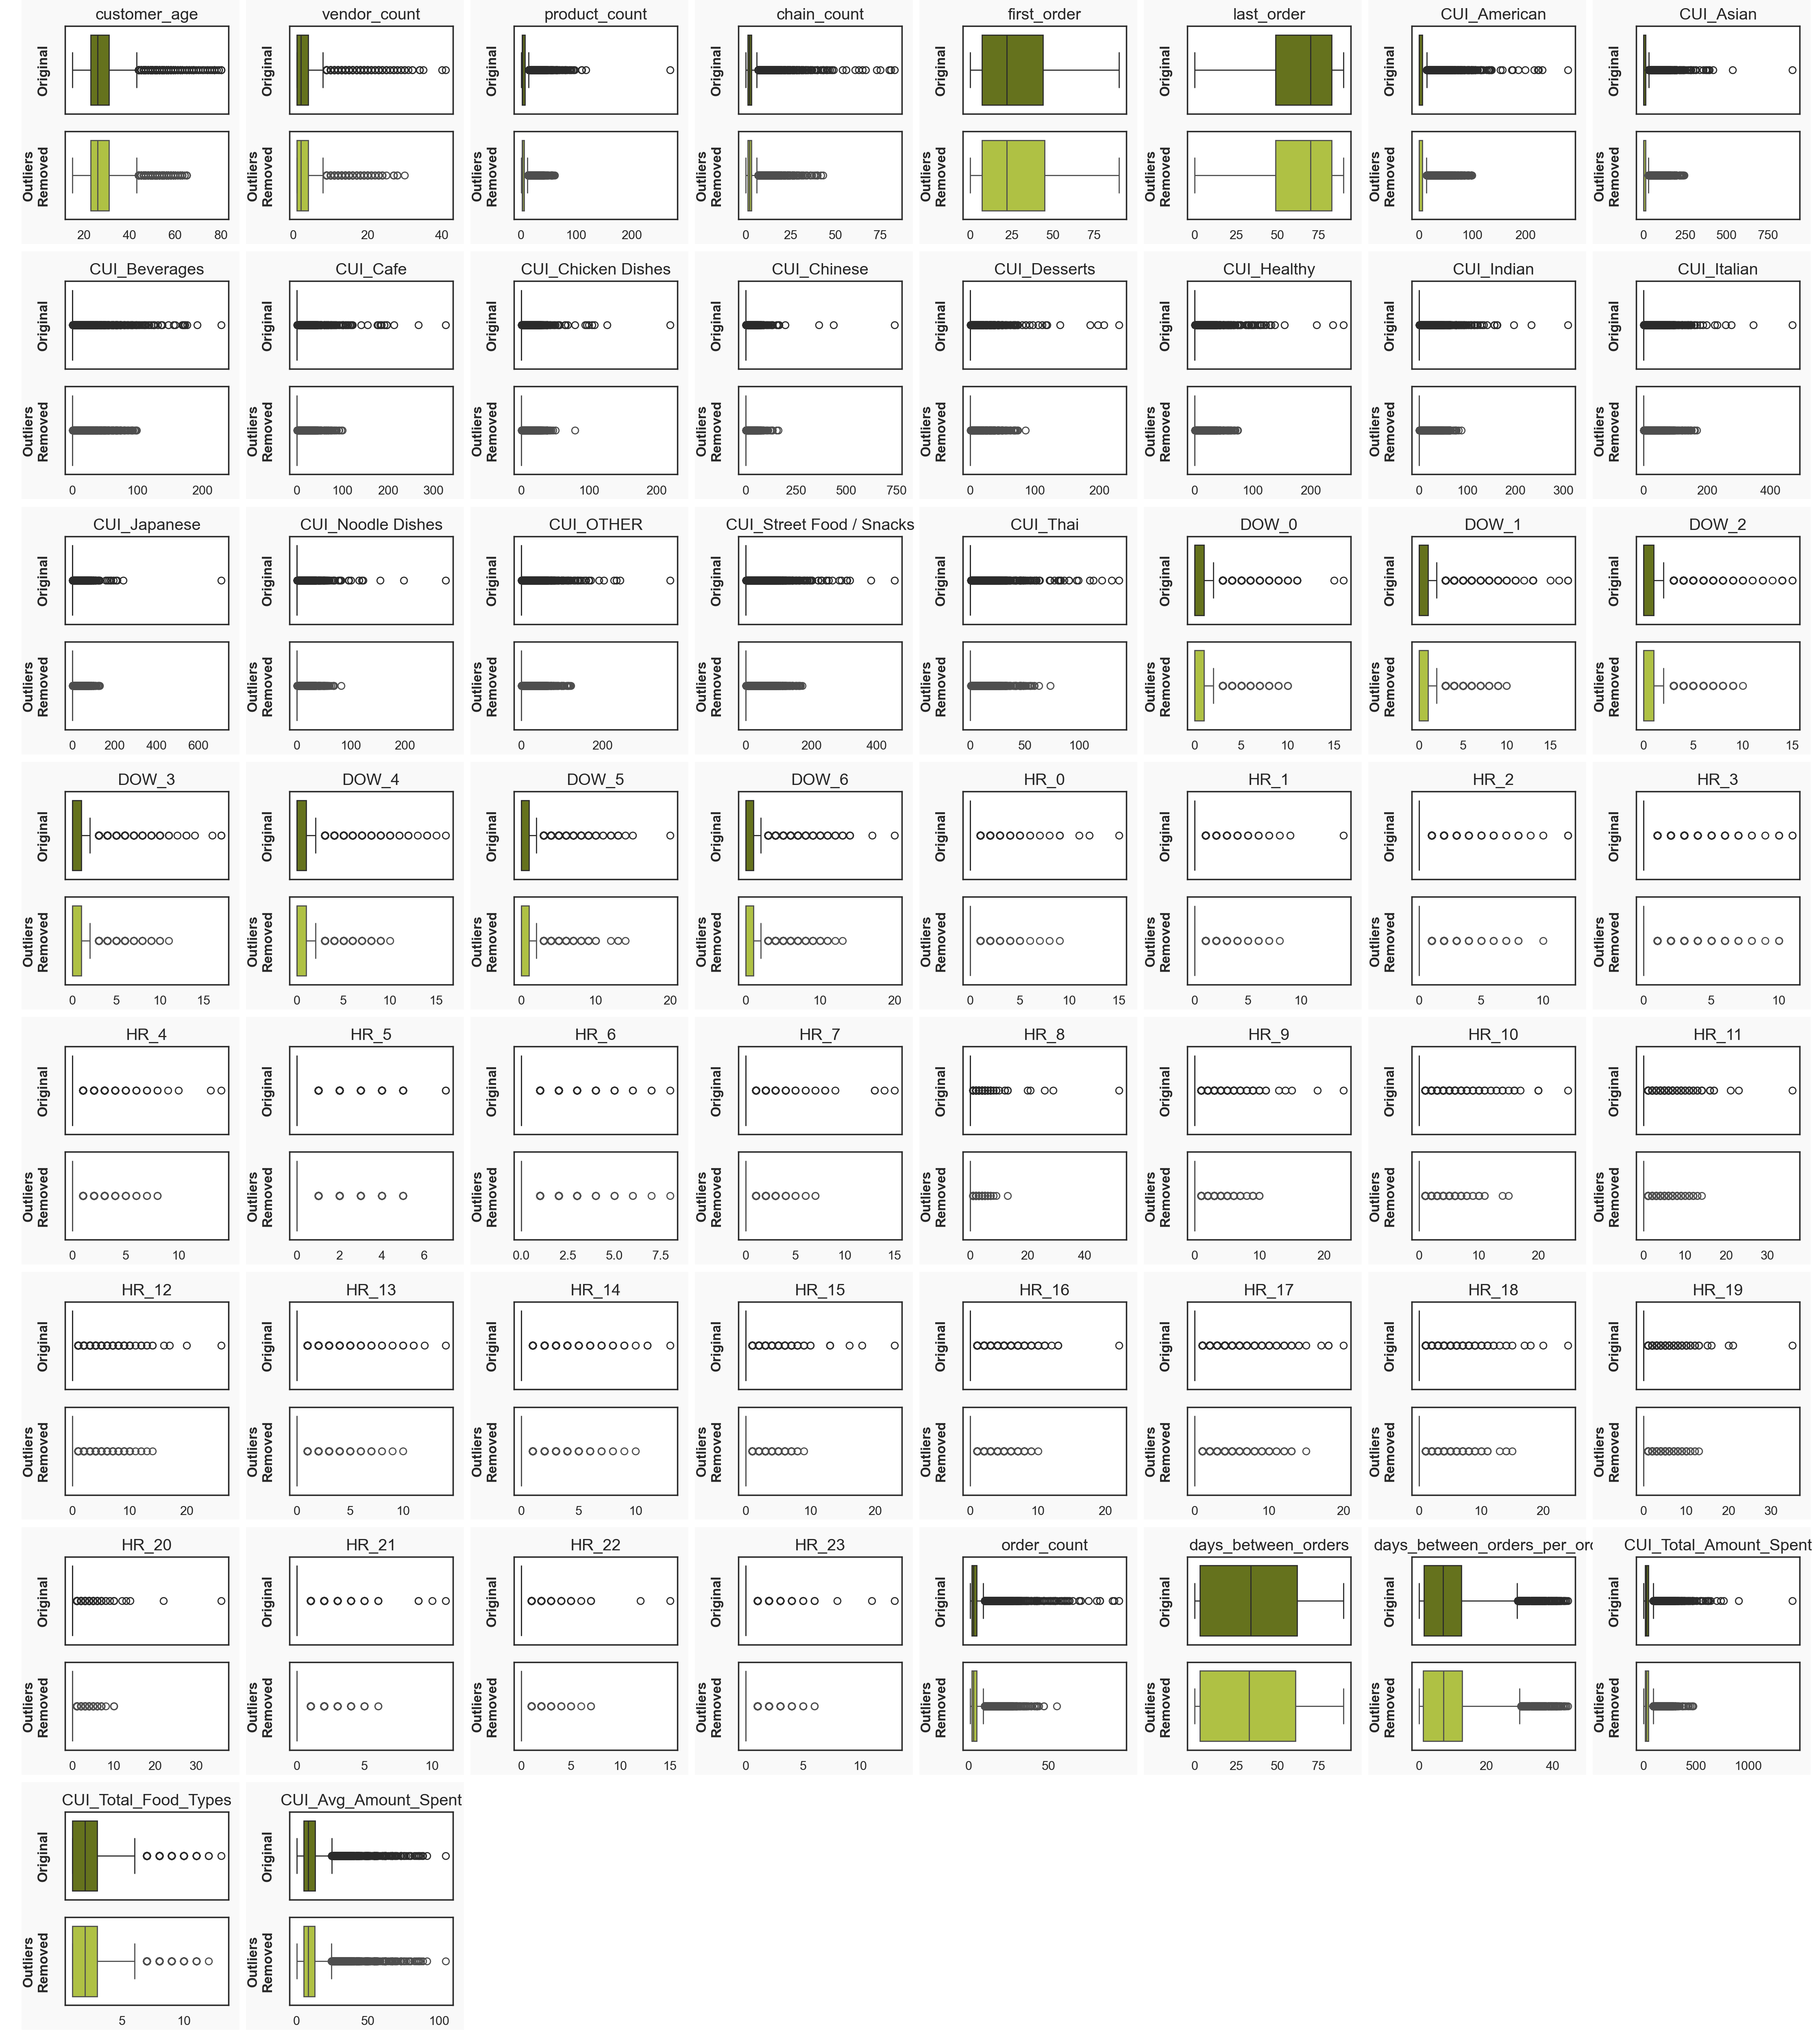

In [70]:
# Boxplots of the metric columns before and after removing the outliers
frows = 8
fcols = ceil(len(metric_cols)/frows)

fig = plt.figure(figsize=(22,25))
subfigs = fig.subfigures(frows, fcols, wspace=.03, hspace=.03)

for sfig, feat in zip(subfigs.flatten(), metric_cols):
    
    # Create 2 subplots
    axes = sfig.subplots(2, 1, sharex=True)
    
    # Boxplot before removing the outliers
    sns.boxplot(x=ABCDEats[feat], ax=axes[0], color='#6f800f')
    axes[0].set_ylabel('Original', fontweight='bold')
    axes[0].set_title(feat, fontsize='large')
    
    # Boxplot after removing the outliers
    sns.boxplot(x=df_out[feat], ax=axes[1], color='#bEd62f')
    axes[1].set_ylabel('\nOutliers\nRemoved', fontweight='bold')
    axes[1].set_xlabel('')

    # Subfigure Aesthetics
    sfig.set_facecolor("#F9F9F9")
    
    sfig.subplots_adjust(left=.2, right=.95, bottom=.1,)

# Save the figure
plt.savefig('./Preprocessing_Outputs/Boxplots_With_Without_Outliers.png', dpi=300, bbox_inches='tight')
plt.show()

<div class="alert alert-block alert-warning">

#### **Outliers Detection**  | Analysis

- 

In [71]:
# # Plot ALL Numeric Variables' Histograms with Boxplots [Before & After Imputation]
# sp_rows = 9
# sp_cols = 6

# # Prepare figure. Create individual axes where each histogram and boxplot will be placed
# fig, axes = plt.subplots(sp_rows * 2, sp_cols,                                        # Create subplots
#                          figsize=(20, 4*sp_rows),                                     # Set the figure size
#                          tight_layout=True,                                           # Automatically adjust subplot parameters to give specified padding
#                          gridspec_kw={'height_ratios': [0.2, 0.8] * sp_rows})         # Set the height ratios of the subplots

# # Adjust the space between subplots
# plt.subplots_adjust(hspace=0.5)  # Increase the vertical space between subplots

# # Plot data
# # Iterate across axes objects and associate each histogram and boxplot
# for i, (ax_box, ax_hist, feat) in enumerate(zip(axes[::2].flatten(), axes[1::2].flatten(), metric_cols)):

#     # Plot the Boxplot on the top
#     sns.boxplot(ABCDEats[feat], color='#bEd62f', orient='h', ax=ax_box, width=0.4, boxprops=dict(alpha=.5))
#     sns.boxplot(df_out[feat], color='#286dec', orient='h', ax=ax_box, width=0.4, boxprops=dict(alpha=.3))
    
#     # Plot the Histogram and the KDE on the bottom
#     sns.histplot(ABCDEats[feat], color='#bEd62f', kde=True, stat='percent', alpha=0.6, ax=ax_hist, label='Original')
#     sns.histplot(df_out[feat], color='#286dec', kde=True, stat='percent', alpha=0.3, ax=ax_hist, label='After Preprocess')
    
#     # Add mean, median and percentiles to the plot
#     mean_val = ABCDEats[feat].mean()
#     median_val = ABCDEats[feat].median()
#     q1_val = ABCDEats[feat].quantile(0.25)
#     q3_val = ABCDEats[feat].quantile(0.75)
    
#     mean_val_neighbors = df_out[feat].mean()
#     median_val_neighbors = df_out[feat].median()
#     q1_val_neighbors = df_out[feat].quantile(0.25)
#     q3_val_neighbors = df_out[feat].quantile(0.75)
    
#     ax_hist.axvline(mean_val, color='#806F0F', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Mean (Original): {mean_val:.1f}')
#     ax_hist.axvline(mean_val_neighbors, color='#B0C4DE', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Mean (After Preprocess): {mean_val_neighbors:.1f}')
#     ax_hist.axvline(median_val, color='#2A3006', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Median (Original): {median_val:.1f}')
#     ax_hist.axvline(median_val_neighbors, color='#4682B4', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Median (After Preprocess): {median_val_neighbors:.1f}')
#     ax_hist.axvline(q1_val, color='#6F0F80', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Q1 (Original): {q1_val:.1f}')
#     ax_hist.axvline(q1_val_neighbors, color='#5F9EA0', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Q1 (After Preprocess): {q1_val_neighbors:.1f}')
#     ax_hist.axvline(q3_val, color='#800F6F', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Q3 (Original): {q3_val:.1f}')
#     ax_hist.axvline(q3_val_neighbors, color='#6495ED', linestyle='--', linewidth=1.5, alpha=0.8, label=f'Q3 (After Preprocess): {q3_val_neighbors:.1f}')

#     # Add a legend to the histogram
#     ax_hist.legend(loc='best',          # Position of the legend (automatic placement to avoid overlapping)
#                    title='Statistics',  # Title of the legend 
#                    title_fontproperties={'weight':'bold',  # Title font weight
#                                          'size':'8'},     # Title font size
#                    fontsize=6,          # Legend font size
#                    labelspacing=0.8,    # Spacing between the legend handles and labels
#                    borderpad=0.8,       # Border pad around the legend
#                    frameon=False)       # Whether to draw a frame around the legend
    
#     # Customizing the titles and labels of the plots
#     ax_box.set_xlabel(None)
#     ax_box.set_ylabel(None)
#     ax_hist.set_title(feat, y=-0.30, fontweight='bold')
#     ax_hist.set_xlabel(None)
#     ax_hist.set_ylabel(None)
    
#     # Add y-label 'Count' to the first plots on the left
#     if i % sp_cols == 0:
#         ax_hist.set_ylabel('Count (n)\n', fontsize=10, fontweight='bold')
    
#     # Remove the top and right spines for a cleaner look
#     sns.despine(ax=ax_box, top=True, right=True)
#     sns.despine(ax=ax_hist, top=True, right=True)

# # Remove any unused subplots (empty subplots)
# axes.flatten()[-1].set_visible(False)
# axes.flatten()[-2].set_visible(False)
# axes.flatten()[-sp_cols-1].set_visible(False)
# axes.flatten()[-sp_cols-2].set_visible(False)

# # Layout
# # Add a centered title to the figure:
# plt.suptitle("Numeric Variables' Histograms with Boxplots\n\n\n", fontweight='bold', fontsize=16)
# fig.savefig('./Preprocessing_Outputs/Numeric_Variables_Histograms_Boxplots.png', dpi=300, bbox_inches='tight')
# plt.show()

![Outliers](./Preprocessing_Outputs/Numeric_Variables_Histograms_Boxplots.png)

<div class="alert alert-block alert-success" style="font-size: 17px">

### Analysis after **Preprocessing**:



##### **Final Decision:**

> AAAAAAAAAAAA

</div>

In [72]:
# Using both filter methods
ABCDEats = df_out.copy()

In [73]:
# Apply the function 'detect_outliers' to all the metric columns
for col in metric_cols:  
    # If it is the first column, save the information about the outliers
    if col == metric_cols[0]:
        outliers_info_after = detect_outliers(ABCDEats, col, info=True)
    else:
        # Combine the information about the outliers of all the columns in a single DataFrame
        outliers_info_after = pd.concat([outliers_info_after, detect_outliers(ABCDEats, col, info=True)], ignore_index=True)
    
    
outliers_info_after.set_index('Feature', inplace=True)

# Personalize the DataFrame with a grey color for the rows without outliers
def highlight_no_outliers(row):
    # Check if the "Number of Outliers" column is zero
    if row['Number of Outliers'] == 0:
        return ['background-color: #ECEDDF'] * len(row)
    return [''] * len(row)

# Apply styling to the DataFrame
outliers_info_after.style.format({
    col: '{:.2f}' for col in outliers_info_after.select_dtypes('float64').columns
}).apply(highlight_no_outliers, axis=1)

,1st Quartile,3rd Quartile,IQR,Lower Bound,Upper Bound,Number of Outliers,Percentage of Outliers (%),Min,Max
Feature,,,,,,,,,
customer_age,23.00,31.00,8.00,11.00,43.00,1020,3.26,44.00,65.00
vendor_count,1.00,4.00,3.00,-3.50,8.50,1344,4.30,9.00,30.00
product_count,2.00,6.00,4.00,-4.00,12.00,2731,8.73,13.00,61.00
chain_count,1.00,3.00,2.00,-2.00,6.00,2891,9.24,7.00,43.00
first_order,7.00,45.00,38.00,-50.00,102.00,0,0.00,nan,nan
last_order,49.00,83.00,34.00,-2.00,134.00,0,0.00,nan,nan
CUI_American,0.00,5.54,5.54,-8.31,13.85,3417,10.92,13.86,99.33
CUI_Asian,0.00,11.79,11.79,-17.68,29.47,3349,10.71,29.49,244.59
CUI_Beverages,0.00,0.00,0.00,0.00,0.00,5314,16.99,0.32,98.95


---

# **📊 Redo EDA After Preprocessing**

## **🔗 Correlation Analysis**

### **Numerical Variable VS Numerical Variable**

 > Compared to the **Pearson correlation** coefficient, the **Spearman correlation** is more robust to outliers and non-linear relationships.

In [74]:
# Enconding 'customer_age_group' to a numerical variable
code_age_group = {'15-28': 1, '29-41': 2, '42-54': 3, '55-67': 4, '68-80': 5}
ABCDEats['customer_age_group'] = ABCDEats['customer_age_group'].map(code_age_group)

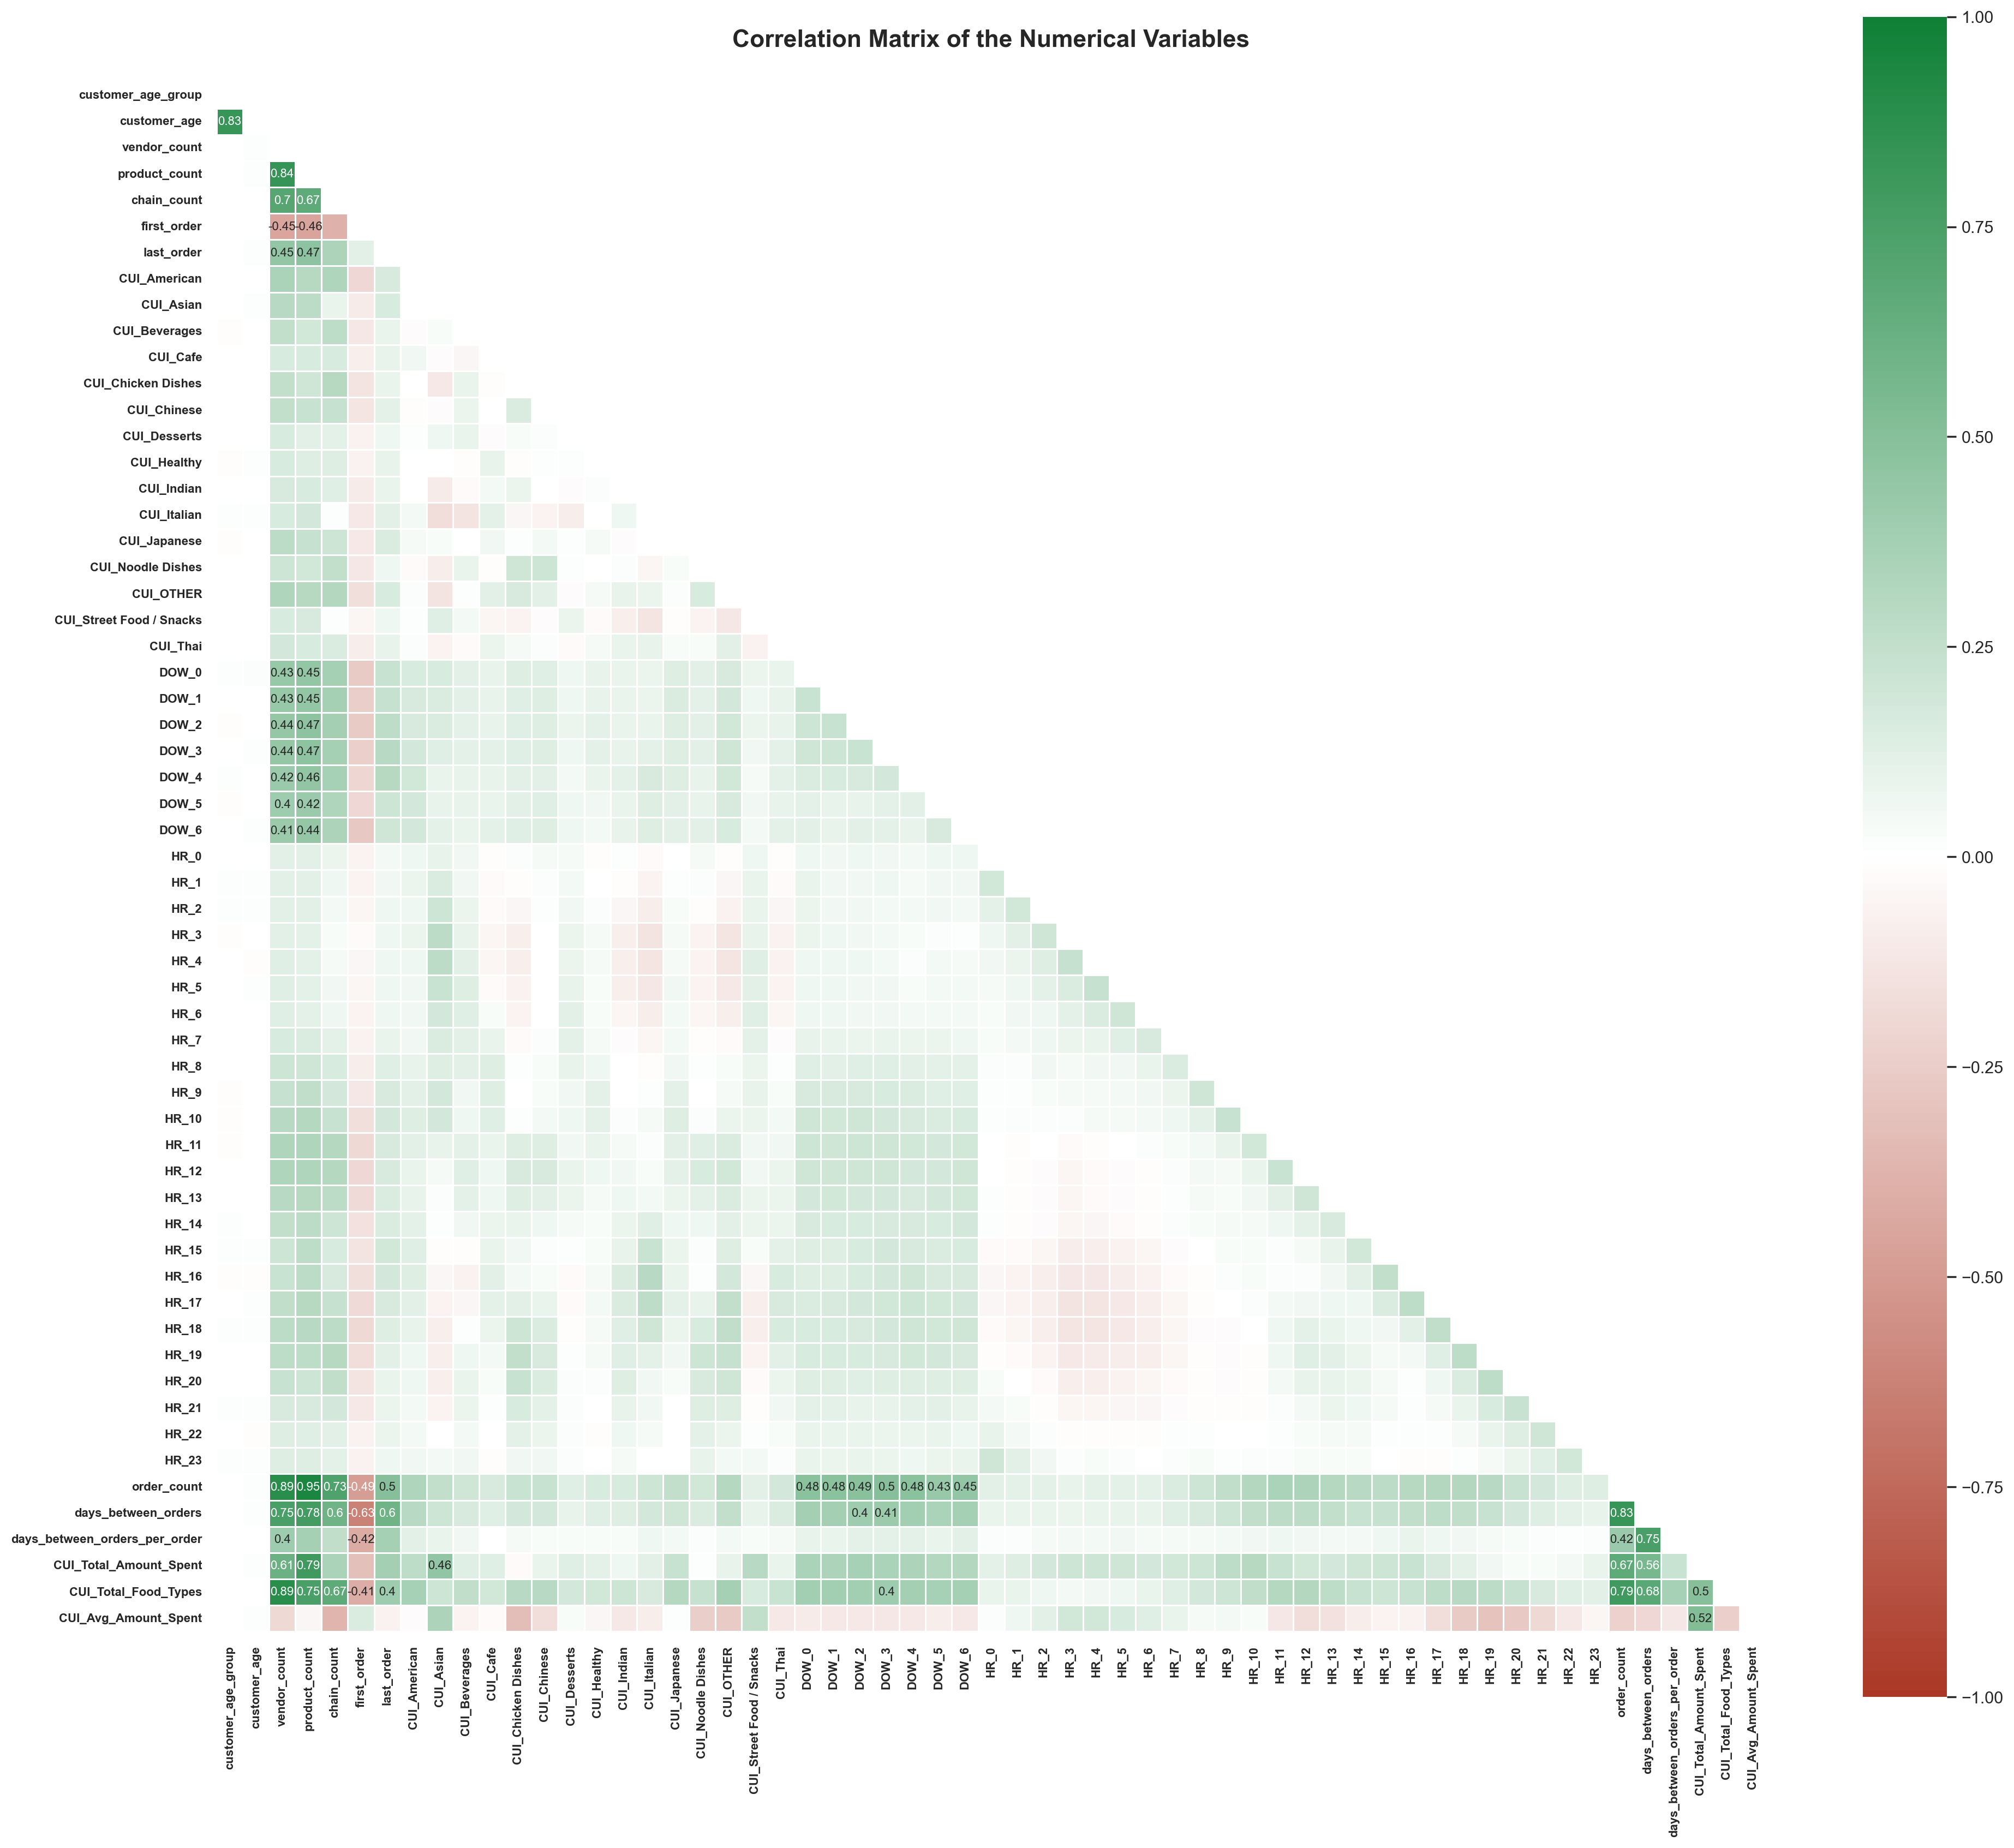

In [75]:
# Correlation Matrix of the all columns - Numerical Variables
correlation = ABCDEats[['customer_age_group'] + metric_cols].corr(method='spearman')              # Because the data is not normally distributed

# Round the values of the correlation matrix to 2 decimal places.
correlation = correlation.round(2)

# Show only high or low values: values above |0.4| will appear annotated in the plot
mask_annot = np.absolute(correlation.values) >= 0.4
annot = np.where(mask_annot, correlation.values, np.full(correlation.shape,""))

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.zeros_like(correlation, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Create a custom diverging palette from red (-1) to white (0) to green (1)
# cmap = sns.diverging_palette(10, 130, s=100, l=50, n=9, center='light', as_cmap=True)
cmap = LinearSegmentedColormap.from_list("correlation_cmap", ["#AB3826", "white", "#0F8036"])

# Plot the correlation matrix as a Heatmap
fig = plt.figure(figsize=(20, 20))
sns.heatmap(correlation, mask=mask, cmap=cmap, annot=annot, fmt='s', 
            annot_kws={'fontsize':8}, cbar_kws={'shrink':0.8},
            vmin=-1, vmax=1, center=0, linewidths=0.5, square=True)
plt.title('Correlation Matrix of the Numerical Variables\n', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=8, fontweight ='bold')
plt.yticks(fontsize=8, fontweight ='bold')
plt.tight_layout()
fig.savefig('./Preprocessing_Outputs/Correlation_Matrix_Numerical_Variables.png', dpi=200, bbox_inches='tight')
plt.show()

In [191]:
# List of features with correlation > 0.8 (Multicollinearity)
for col in correlation.columns:
    if correlation[col][(correlation[col] > 0.8) & (correlation[col] < 1)].any():
        print(f"\nFeatures with correlation > 0.8 with {col}:")
        print(correlation[col][(correlation[col] > 0.8) & (correlation[col] < 1)].to_dict())


Features with correlation > 0.8 with customer_age_group:
{'customer_age': 0.83}

Features with correlation > 0.8 with customer_age:
{'customer_age_group': 0.83}

Features with correlation > 0.8 with vendor_count:
{'product_count': 0.84, 'order_count': 0.89, 'CUI_Total_Food_Types': 0.89}

Features with correlation > 0.8 with product_count:
{'vendor_count': 0.84, 'order_count': 0.95}

Features with correlation > 0.8 with order_count:
{'vendor_count': 0.89, 'product_count': 0.95, 'days_between_orders': 0.83}

Features with correlation > 0.8 with days_between_orders:
{'order_count': 0.83}

Features with correlation > 0.8 with CUI_Total_Food_Types:
{'vendor_count': 0.89}


In [192]:
# See the results of multicollinearity after drop 'vender_count' + 'product_count' + 'days_between_orders' + 'customer_age_group'
correlation = ABCDEats[['customer_age_group'] + metric_cols].drop(columns=['vendor_count', 'product_count', 'days_between_orders', 'customer_age_group']).corr(method='spearman')              # Because ...

# List of features with correlation > 0.8 (Multicollinearity)
for col in correlation.columns:
    if correlation[col][(correlation[col] > 0.8) & (correlation[col] < 1)].any():
        print(f"\nFeatures with correlation > 0.8 with {col}:")
        print(correlation[col][(correlation[col] > 0.8) & (correlation[col] < 1)].to_dict())

---

### **Categorical Variable VS Categorical Variable**

> To calculate the correlation between two categorical variables, we will use the **Cramer's V correlation**.

<br><br>

#### **Cramer's V Correlation** <sup>[4]</sup>

Cramér's V (Cramér, 1946) is measure is actually designed for the chi-square test for independence but can be adjusted for the goodness-of-fit test (Kelley & Preacher, 2012, p. 145; Mangiafico, 2016, p. 474) <sup>[5]</sup><sup>[6]</sup>. It gives an estimate of how well the data then fits the expected values, where 0 would indicate that they are exactly equal. If you use the equal distributed expected values (as we did in the example) the maximum value would be 1, otherwise it could actually also exceed 1.

Its formula is:

\begin{equation*}
V_{gof} = \sqrt{\frac{\chi^2}{n \times df}}
\end{equation*}

Where $\chi^2$ is the chi-square value of the chi-square test, $n$ the number of data points, and $df$ the degrees of freedom, which is the number of categories, minus one in for this.

<br>

Cohen shown that Cramér's V can be converted to Cohen's w using (Cohen, 1988, p. 223) <sup>[7]</sup>:

$$w = V_{gof}\times \sqrt{df}$$

We could then use Cohen's rule-of-thumb for the interpertation (Cohen, 1988, pp. 224-225) <sup>[7]</sup>:

| Cohen w      | Interpretation |
|--------------|----------------|
| 0 < .10      | Negligible     |
| 0.10 < 0.30  | Small          |
| 0.30 < 0.50  | Medium         |
| 0.50 or more | Large          |

<br>


In [193]:
# Correlation Matrix of the all columns - Categorical Variables [Cramer's V Correlation]
# Source: https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix

# OHE encoding of the categorical variables for the calculation of the Cramer's V correlation
df_ohe = ABCDEats.copy()
ohe = OneHotEncoder(sparse_output=False, drop="first")
ohe_feat = ohe.fit_transform(df_ohe[list(set(non_metric_cols) - {'customer_age_group'})])
ohe_feat_names = ohe.get_feature_names_out()

# Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
df_ohe = pd.DataFrame(ohe_feat, columns=ohe_feat_names, index=df_ohe.index)
df_ohe = df_ohe[df_ohe.columns.sort_values()]
df_ohe[ohe_feat_names]

,payment_method_CASH,payment_method_DIGI,last_promo_bin_True,customer_region_2440,customer_region_2490,customer_region_4140,customer_region_4660,customer_region_8370,customer_region_8550,customer_region_8670,customer_region_Unknown,customer_region_buckets_4,customer_region_buckets_8,customer_region_buckets_U,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO PROMO,CUI_Most_Spent_Cuisine_Asian,CUI_Most_Spent_Cuisine_Beverages,CUI_Most_Spent_Cuisine_Cafe,CUI_Most_Spent_Cuisine_Chicken Dishes,CUI_Most_Spent_Cuisine_Chinese,CUI_Most_Spent_Cuisine_Desserts,CUI_Most_Spent_Cuisine_Healthy,CUI_Most_Spent_Cuisine_Indian,CUI_Most_Spent_Cuisine_Italian,CUI_Most_Spent_Cuisine_Japanese,CUI_Most_Spent_Cuisine_Noodle Dishes,CUI_Most_Spent_Cuisine_OTHER,CUI_Most_Spent_Cuisine_Street Food / Snacks,CUI_Most_Spent_Cuisine_Thai
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
31884,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
31885,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [194]:
# Concatenate the one-hot encoded categorical features into the original DataFrame ABCDEats
ABCDEats = pd.concat([ABCDEats, df_ohe[ohe_feat_names]], axis=1)

In [195]:
# Calculate the Cramer's V correlation matrix
# Source: https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792
import scipy.stats as ss

def cramers_v(var1,var2):
    """
    Calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(var1,var2).values
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Building of the matrix
rows= []

# Append 'customer_age_group' to the DataFrame
df_ohe['customer_age_group'] = ABCDEats['customer_age_group']

# Sort the columns of the DataFrame
df_ohe = df_ohe[df_ohe.columns.sort_values()]

for var1 in tqdm(df_ohe.columns):
  col = []
  for var2 in df_ohe.columns:
    cramers =cramers_v(df_ohe[var1], df_ohe[var2]) # Cramer's V Test
    col.append(round(cramers,2))                   # Keeping of the rounded value of the Cramer's V
  rows.append(col)

cramers_results = np.array(rows)
cramers_results_df = pd.DataFrame(cramers_results, columns = df_ohe.columns, index = df_ohe.columns)
cramers_results_df

100%|██████████| 32/32 [00:05<00:00,  5.87it/s]


,CUI_Most_Spent_Cuisine_Asian,CUI_Most_Spent_Cuisine_Beverages,CUI_Most_Spent_Cuisine_Cafe,CUI_Most_Spent_Cuisine_Chicken Dishes,CUI_Most_Spent_Cuisine_Chinese,CUI_Most_Spent_Cuisine_Desserts,CUI_Most_Spent_Cuisine_Healthy,CUI_Most_Spent_Cuisine_Indian,CUI_Most_Spent_Cuisine_Italian,CUI_Most_Spent_Cuisine_Japanese,CUI_Most_Spent_Cuisine_Noodle Dishes,CUI_Most_Spent_Cuisine_OTHER,CUI_Most_Spent_Cuisine_Street Food / Snacks,CUI_Most_Spent_Cuisine_Thai,customer_age_group,customer_region_2440,customer_region_2490,customer_region_4140,customer_region_4660,customer_region_8370,customer_region_8550,customer_region_8670,customer_region_Unknown,customer_region_buckets_4,customer_region_buckets_8,customer_region_buckets_U,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO PROMO,last_promo_bin_True,payment_method_CASH,payment_method_DIGI
CUI_Most_Spent_Cuisine_Asian,1.00,0.14,0.06,0.10,0.11,0.07,0.08,0.13,0.18,0.15,0.09,0.18,0.15,0.08,0.00,0.07,0.05,0.07,0.14,0.09,0.01,0.38,0.06,0.16,0.40,0.06,0.02,0.03,0.00,0.00,0.01,0.01
CUI_Most_Spent_Cuisine_Beverages,0.14,1.00,0.03,0.05,0.05,0.04,0.04,0.06,0.09,0.07,0.04,0.09,0.07,0.04,0.00,0.02,0.03,0.04,0.17,0.00,0.00,0.08,0.02,0.18,0.08,0.02,0.00,0.01,0.02,0.02,0.02,0.00
CUI_Most_Spent_Cuisine_Cafe,0.06,0.03,1.00,0.02,0.02,0.02,0.02,0.03,0.04,0.03,0.02,0.04,0.03,0.02,0.00,0.00,0.01,0.00,0.13,0.01,0.00,0.08,0.01,0.13,0.08,0.01,0.00,0.01,0.00,0.00,0.00,0.00
CUI_Most_Spent_Cuisine_Chicken Dishes,0.10,0.05,0.02,1.00,0.04,0.03,0.03,0.04,0.06,0.05,0.03,0.06,0.05,0.03,0.00,0.06,0.07,0.03,0.11,0.02,0.00,0.13,0.02,0.11,0.13,0.02,0.01,0.00,0.01,0.01,0.01,0.00
CUI_Most_Spent_Cuisine_Chinese,0.11,0.05,0.02,0.04,1.00,0.03,0.03,0.05,0.07,0.06,0.03,0.07,0.06,0.03,0.00,0.07,0.01,0.03,0.10,0.01,0.00,0.07,0.01,0.11,0.07,0.01,0.00,0.00,0.01,0.01,0.00,0.00
CUI_Most_Spent_Cuisine_Desserts,0.07,0.04,0.02,0.03,0.03,1.00,0.02,0.03,0.05,0.04,0.02,0.05,0.04,0.02,0.00,0.00,0.01,0.02,0.09,0.04,0.00,0.10,0.01,0.10,0.11,0.01,0.02,0.01,0.02,0.02,0.00,0.01
CUI_Most_Spent_Cuisine_Healthy,0.08,0.04,0.02,0.03,0.03,0.02,1.00,0.03,0.05,0.04,0.02,0.05,0.04,0.02,0.01,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00
CUI_Most_Spent_Cuisine_Indian,0.13,0.06,0.03,0.04,0.05,0.03,0.03,1.00,0.08,0.07,0.04,0.08,0.06,0.04,0.00,0.01,0.00,0.01,0.08,0.03,0.00,0.15,0.03,0.08,0.16,0.03,0.00,0.00,0.01,0.01,0.00,0.01
CUI_Most_Spent_Cuisine_Italian,0.18,0.09,0.04,0.06,0.07,0.05,0.05,0.08,1.00,0.09,0.05,0.11,0.09,0.05,0.00,0.05,0.03,0.22,0.32,0.04,0.00,0.22,0.04,0.39,0.22,0.04,0.01,0.04,0.09,0.09,0.04,0.06
CUI_Most_Spent_Cuisine_Japanese,0.15,0.07,0.03,0.05,0.06,0.04,0.04,0.07,0.09,1.00,0.05,0.09,0.08,0.04,0.00,0.02,0.01,0.02,0.06,0.02,0.00,0.02,0.00,0.05,0.03,0.00,0.00,0.00,0.01,0.01,0.00,0.01


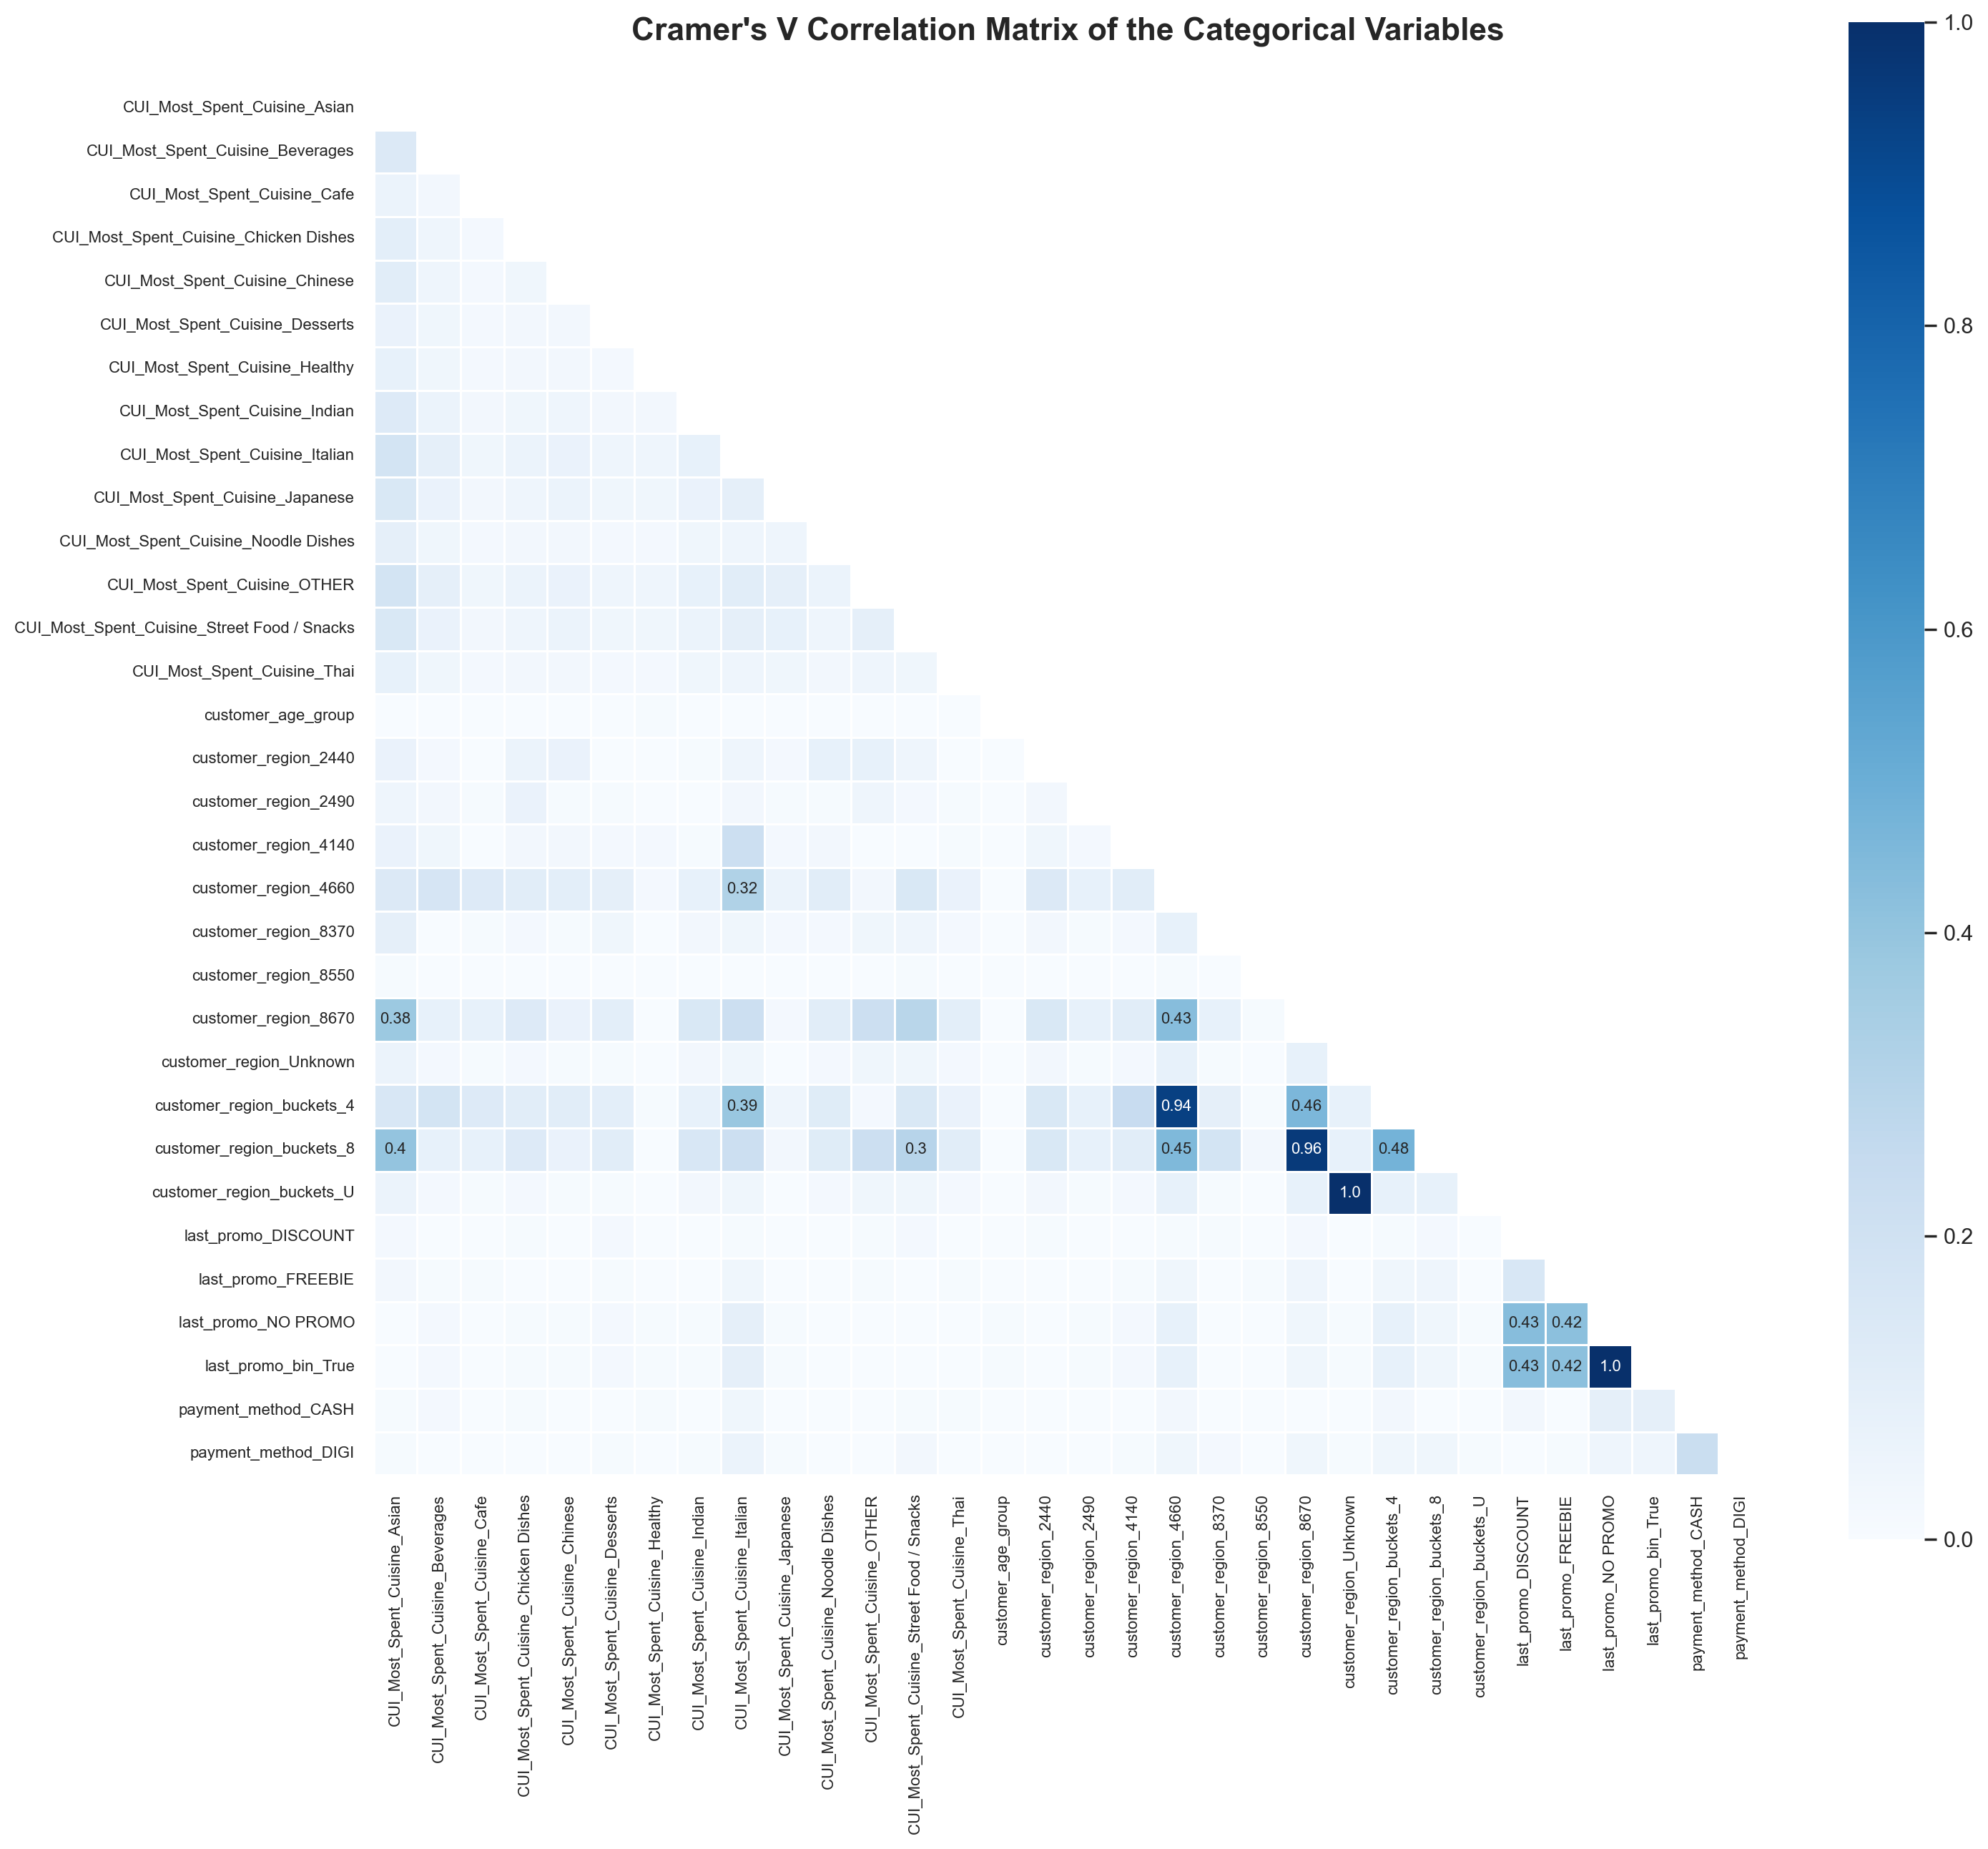

In [196]:
# Heatmap of the Cramer's V correlation matrix

# Show only high or low values: values above |0.3| will appear annotated in the plot
mask_annot = np.absolute(cramers_results_df.values) >= 0.3
annot = np.where(mask_annot, cramers_results_df.values, np.full(cramers_results_df.shape,""))

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.zeros_like(cramers_results_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix as a Heatmap
fig = plt.figure(figsize=(15, 15))
sns.heatmap(cramers_results_df,
            cmap='Blues',
            annot=annot,    # Show only VERY high or VERY low values
            fmt='s',        # fmt='s' -> string format
            # annot=True, 
            # fmt='.2f',
            annot_kws={'fontsize':8},
            cbar_kws={'shrink':0.8},
            vmin=0, vmax=1, center=0.5,
            linewidths=0.5, square=True, mask=mask)
plt.title("Cramer's V Correlation Matrix of the Categorical Variables\n", fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks(ticks=np.arange(len(cramers_results_df.columns)) + 0.5, # Center the ticks
           labels=cramers_results_df.columns,
           fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
fig.savefig('./Preprocessing_Outputs/Cramers_V_Correlation_Matrix_Categorical_Variables.png', dpi=200, bbox_inches='tight')
plt.show()

---

#  **🕵️‍♂️ PCA (Principal Component Analysis)**

#### **Scaling Data** [StandardScaler]

In [197]:
ABCDEats_standard = ABCDEats.copy()

In [198]:
ss_scaler = StandardScaler()
ss_scaled_feat = ss_scaler.fit_transform(ABCDEats[metric_cols])
ss_scaled_feat

array([[-1.36983173, -0.40318759, -0.05775885, ..., -0.18745187,
        -0.86991998,  0.53359622],
       [-1.5148368 , -0.40318759, -0.59732256, ..., -0.44463931,
        -0.17941023, -0.08464912],
       [ 1.53026958, -0.79180168, -0.59732256, ..., -0.71086953,
        -0.86991998, -0.72463215],
       ...,
       [-0.49980134, -0.79180168, -0.77717712, ..., -0.48240623,
        -0.86991998,  0.96195649],
       [ 0.95024931, -0.79180168, -0.77717712, ..., -0.63560165,
        -0.86991998,  0.22543257],
       [ 0.37022905, -0.79180168, -0.77717712, ..., -0.74517892,
        -0.86991998, -0.30138663]])

In [199]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n")
pd.DataFrame([ss_scaler.mean_, np.sqrt(ss_scaler.var_)], columns=metric_cols, index=['mean','std'])

Parameters fitted:



,customer_age,vendor_count,product_count,chain_count,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
mean,27.45,3.04,5.32,2.68,28.55,63.51,4.62,9.57,2.14,0.64,0.72,1.34,0.82,0.81,1.44,3.10,2.86,0.66,2.78,3.65,0.76,0.52,0.53,0.56,0.58,0.64,0.63,0.67,0.05,0.05,0.06,0.11,0.10,0.08,0.07,0.07,0.12,0.22,0.31,0.36,0.30,0.23,0.21,0.26,0.34,0.37,0.32,0.23,0.14,0.07,0.05,0.04,4.14,34.95,8.53,35.93,2.26,10.27
std,6.90,2.57,5.56,3.40,24.08,23.19,10.21,20.98,7.20,4.30,2.97,5.96,4.35,4.26,5.74,10.03,8.64,3.62,8.13,13.43,3.64,0.91,0.93,0.94,0.96,0.99,0.99,1.07,0.27,0.30,0.32,0.48,0.41,0.34,0.31,0.32,0.45,0.63,0.77,0.85,0.77,0.59,0.56,0.66,0.80,0.87,0.82,0.71,0.51,0.32,0.26,0.25,4.19,29.18,7.92,37.60,1.45,7.82


In [200]:
ABCDEats_standard[metric_cols] = ss_scaled_feat
ABCDEats_standard.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,chain_count,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent,payment_method_CASH,payment_method_DIGI,last_promo_bin_True,customer_region_2440,customer_region_2490,customer_region_4140,customer_region_4660,customer_region_8370,customer_region_8550,customer_region_8670,customer_region_Unknown,customer_region_buckets_4,customer_region_buckets_8,customer_region_buckets_U,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO PROMO,CUI_Most_Spent_Cuisine_Asian,CUI_Most_Spent_Cuisine_Beverages,CUI_Most_Spent_Cuisine_Cafe,CUI_Most_Spent_Cuisine_Chicken Dishes,CUI_Most_Spent_Cuisine_Chinese,CUI_Most_Spent_Cuisine_Desserts,CUI_Most_Spent_Cuisine_Healthy,CUI_Most_Spent_Cuisine_Indian,CUI_Most_Spent_Cuisine_Italian,CUI_Most_Spent_Cuisine_Japanese,CUI_Most_Spent_Cuisine_Noodle Dishes,CUI_Most_Spent_Cuisine_OTHER,CUI_Most_Spent_Cuisine_Street Food / Snacks,CUI_Most_Spent_Cuisine_Thai
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1b8f824d5e,2360,-1.37,-0.40,-0.06,-0.49,-1.19,-2.70,DELIVERY,DIGI,-0.45,-0.46,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,4.78,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,0.52,-0.57,-0.59,-0.61,-0.65,-0.63,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,-0.40,-0.42,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,2.04,-0.33,-0.27,-0.21,-0.17,-0.17,-0.51,2,1,-1.16,-1.01,True,-0.19,Indian,-0.87,0.53,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,5d272b9dcb,8670,-1.51,-0.40,-0.60,-0.20,-1.19,-2.70,DISCOUNT,DIGI,0.80,-0.15,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,0.52,-0.57,-0.59,-0.61,-0.65,-0.63,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,0.90,0.76,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,-0.51,8,1,-1.16,-1.01,True,-0.44,American,-0.18,-0.08,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,f6d1b2ba63,4660,1.53,-0.79,-0.60,-0.20,-1.19,-2.70,DISCOUNT,CASH,0.45,-0.46,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,0.52,-0.57,-0.59,-0.61,-0.65,-0.63,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,1.24,-0.40,0.76,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,-0.51,4,2,-1.16,-1.01,True,-0.71,American,-0.87,-0.72,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,180c632ed8,4660,-0.50,-0.40,-0.42,-0.49,-1.19,-2.65,DELIVERY,DIGI,-0.45,0.20,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,2.86,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,-0.57,0.51,-0.59,-0.61,-0.65,-0.63,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,-0.40,0.76,-0.39,-0.38,1.43,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,-0.51,4,1,-1.13,-0.95,True,-0.12,Indian,-0.18,0.70,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4eb37a6705,4660,-1.08,-0.40,-0.06,-0.79,-1.19,-2.65,NO PROMO,DIGI,0.97,1.49,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,-0.57,0.51,-0.59,-0.6

In [201]:
# Checking mean and variance of standardized variables
ABCDEats_standard[metric_cols].describe().round(2)

,customer_age,vendor_count,product_count,chain_count,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,days_between_orders,days_between_orders_per_order,CUI_Total_Amount_Spent,CUI_Total_Food_Types,CUI_Avg_Amount_Spent
count,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00,31279.00
mean,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.80,-0.79,-0.78,-0.79,-1.19,-2.74,-0.45,-0.46,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,-0.57,-0.57,-0.59,-0.61,-0.65,-0.63,-0.63,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,-0.40,-0.42,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,-0.75,-1.20,-1.08,-0.95,-0.87,-1.27
25%,-0.64,-0.79,-0.60,-0.49,-0.90,-0.63,-0.45,-0.46,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,-0.57,-0.57,-0.59,-0.61,-0.65,-0.63,-0.63,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,-0.40,-0.42,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,-0.51,-1.10,-0.93,-0.61,-0.87,-0.67
50%,-0.21,-0.40,-0.42,-0.20,-0.27,0.28,-0.45,-0.46,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,-0.57,-0.57,-0.59,-0.61,-0.65,-0.63,-0.63,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,-0.40,-0.42,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,-0.27,-0.07,-0.16,-0.32,-0.18,-0.27
75%,0.52,0.37,0.12,0.09,0.68,0.84,0.09,0.11,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,0.52,0.51,0.47,0.43,0.36,0.37,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,-0.40,-0.42,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,0.21,0.89,0.54,0.21,0.51,0.33
max,5.45,10.48,10.01,11.87,2.55,1.14,9.27,11.20,13.44,23.01,26.34,26.80,19.45,17.12,15.05,16.35,14.52,22.51,14.60,12.59,19.95,10.39,10.23,10.06,10.83,9.50,13.45,11.54,32.71,26.76,31.07,20.75,19.47,14.37,25.35,21.67,28.72,15.43,19.14,16.10,17.83,16.52,17.58,13.27,12.13,16.74,17.84,17.99,19.53,18.44,26.61,23.44,12.14,1.89,4.54,11.59,6.73,12.03


In [202]:
df_pca = ABCDEats_standard.copy()

In [203]:
# Check NAs
ABCDEats_standard.isna().sum().sum()

0

---

#### **PCA** [`CUI`]

In [204]:
cuisines_cols

['CUI_American',
 'CUI_Asian',
 'CUI_Beverages',
 'CUI_Cafe',
 'CUI_Chicken Dishes',
 'CUI_Chinese',
 'CUI_Desserts',
 'CUI_Healthy',
 'CUI_Indian',
 'CUI_Italian',
 'CUI_Japanese',
 'CUI_Noodle Dishes',
 'CUI_OTHER',
 'CUI_Street Food / Snacks',
 'CUI_Thai',
 'CUI_Total_Amount_Spent',
 'CUI_Most_Spent_Cuisine',
 'CUI_Total_Food_Types',
 'CUI_Avg_Amount_Spent']

In [205]:
# Use PCA to reduce dimensionality of data
pca_cui = PCA()
cuisines_cols_excluded_cols = ['CUI_Total_Amount_Spent', 'CUI_Most_Spent_Cuisine', 'CUI_Total_Food_Types', 'CUI_Avg_Amount_Spent']
cuisines_cols_selected_cols = [col for col in cuisines_cols if col not in cuisines_cols_excluded_cols]
pca_feat_cui = pca_cui.fit_transform(df_pca[cuisines_cols_selected_cols])
pca_feat_cui

array([[ 1.14641574, -0.3905226 , -1.06229834, ...,  0.48922801,
        -0.35740186, -0.10175975],
       [-0.21213324, -0.05362721, -0.55049918, ..., -0.47964273,
        -0.08255735, -0.25403211],
       [-0.10735476, -0.30600141, -0.64358255, ..., -0.41045881,
        -0.11255183, -0.39477523],
       ...,
       [-1.27428978, -0.02090462,  0.29144207, ..., -0.72815862,
        -0.19280815, -0.57122515],
       [-0.35138669, -0.48756239, -0.59308248, ..., -0.41048751,
         0.09357337,  0.26329221],
       [ 0.11914088, -0.48572515, -0.87881541, ...,  0.11814348,
        -0.1080344 ,  0.07210004]])

In [206]:
# Get PCA output as table

# Get the eigenvalues (explained variance)
explained_variance = pca_cui.explained_variance_ 

# Get the explained variance ratio
explained_variance_ratio = pca_cui.explained_variance_ratio_ 

# get the cumulative explained variance ratio 
# Hint: use np.cumsum()
cumulative_explained_variance_ratio = np.cumsum(pca_cui.explained_variance_ratio_)          

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca_cui.n_components_ + 1)
)

def _eigenvalue_highlighter(row):
    """
    Highlight row with eigenvalue greater than 1
    """
    if row['Eigenvalue'] >=1:
        return ['background-color: #f5fcce'] * len(row)
    return [''] * len(row)

# Apply styling to the DataFrame
pca_results.style.format({
    'Eigenvalue': '{:.2f}',
    'Difference': '{:.2f}',
    'Proportion': '{:.2f}',
    'Cumulative': '{:.2f}'
}).apply(_eigenvalue_highlighter, axis=1)

,Eigenvalue,Difference,Proportion,Cumulative
1,1.57,0.00,0.10,0.10
2,1.35,-0.22,0.09,0.19
3,1.26,-0.09,0.08,0.28
4,1.02,-0.24,0.07,0.35
5,0.99,-0.03,0.07,0.41
6,0.97,-0.03,0.06,0.48
7,0.93,-0.04,0.06,0.54
8,0.91,-0.02,0.06,0.60
9,0.91,-0.00,0.06,0.66
10,0.90,-0.02,0.06,0.72


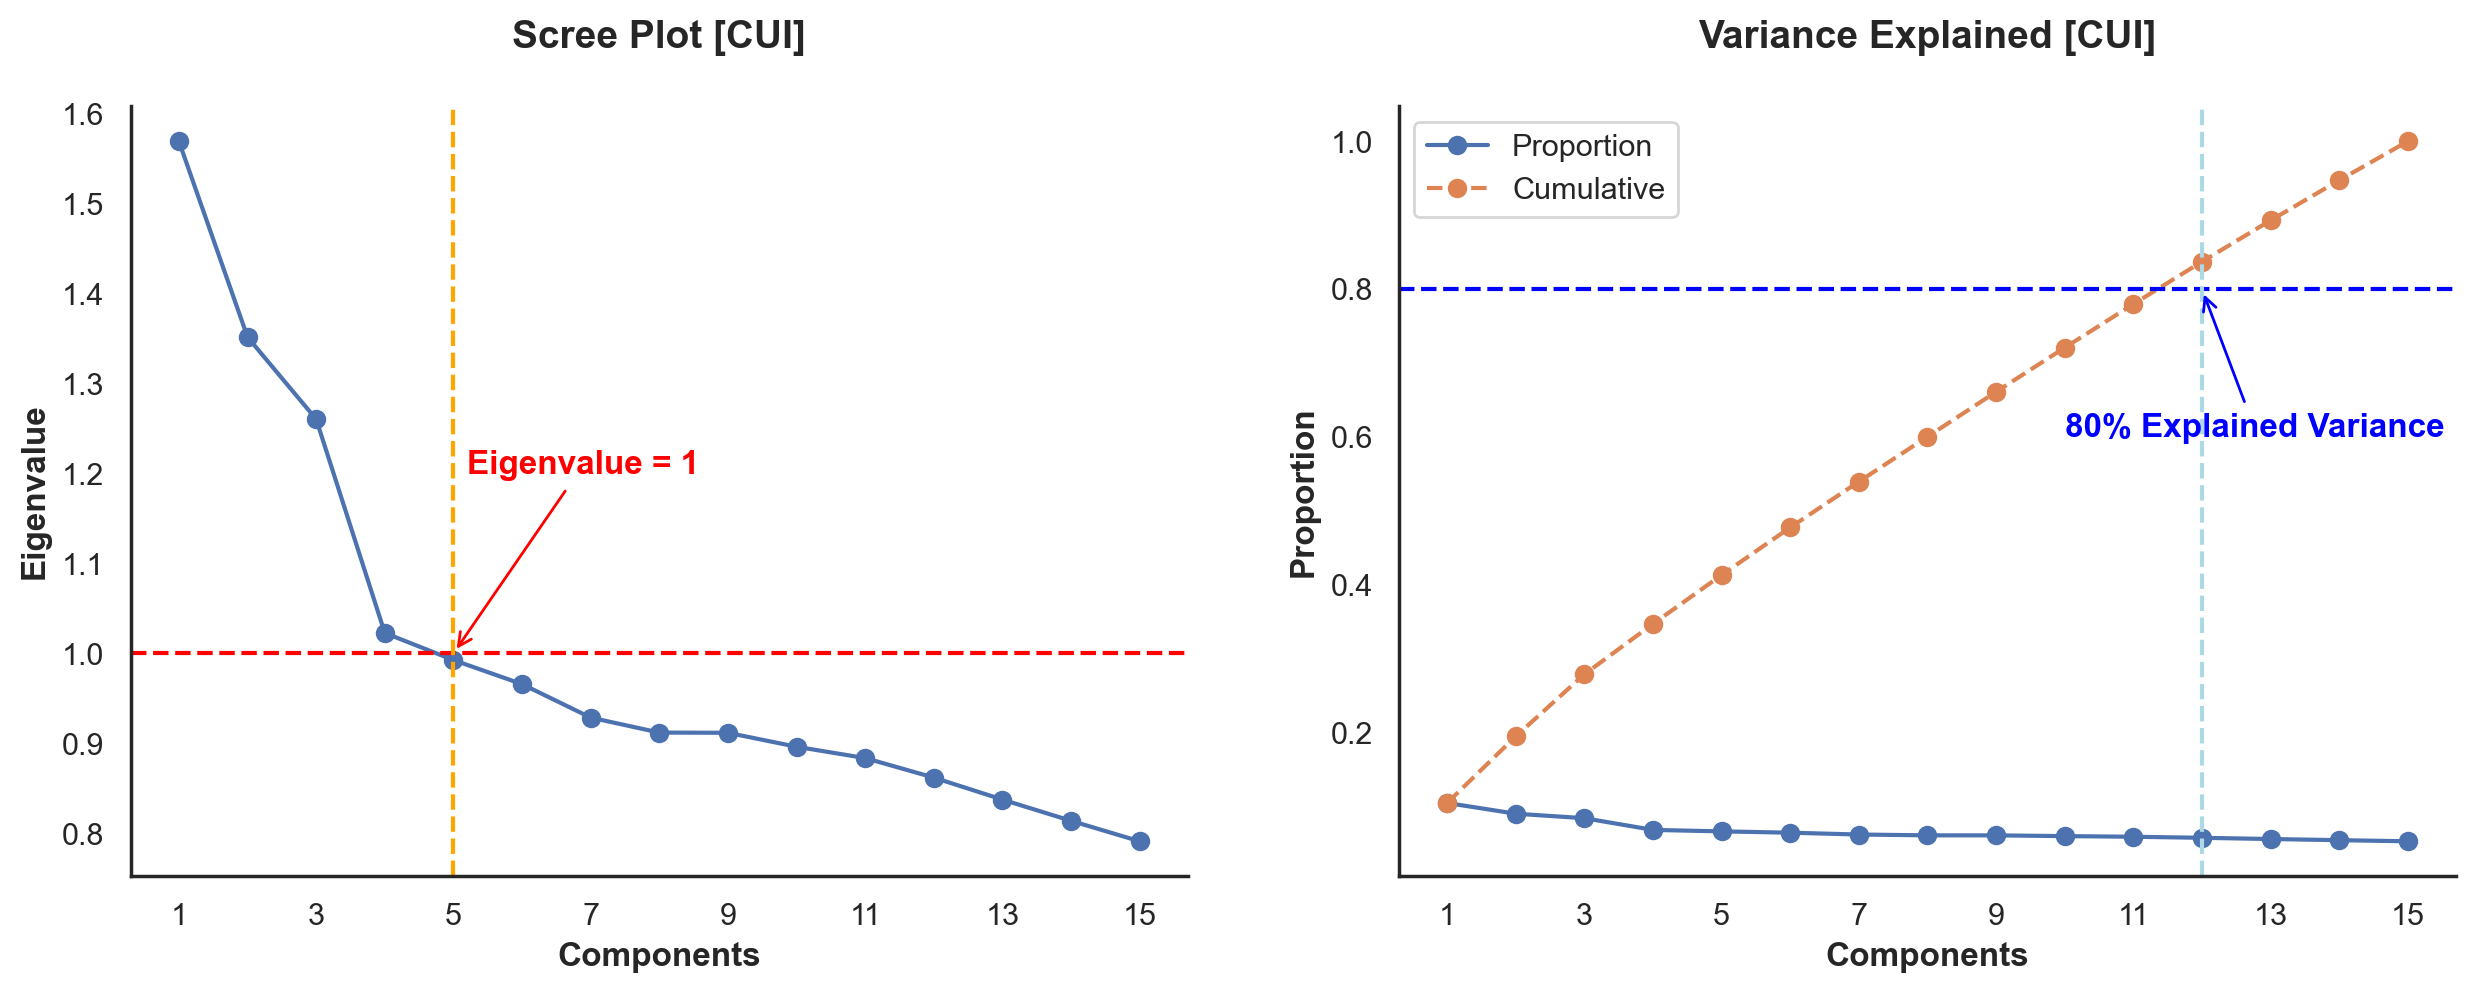

In [207]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots

ax1.plot(explained_variance, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

ax2.plot(explained_variance_ratio, # PLOT THE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, label="Proportion")

ax2.plot(cumulative_explained_variance_ratio, # PLOT THE CUMULATIVE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot [CUI]\n", fontsize=14, fontweight="bold")
ax2.set_title("Variance Explained [CUI]\n", fontsize=14, fontweight="bold")
ax1.set_ylabel("Eigenvalue", fontsize=12, fontweight="bold")
ax2.set_ylabel("Proportion", fontsize=12, fontweight="bold")
ax1.set_xlabel("Components", fontsize=12, fontweight="bold")
ax2.set_xlabel("Components", fontsize=12, fontweight="bold")
ax1.set_xticks(range(0, pca_cui.n_components_, 2))
ax1.set_xticklabels(range(1, pca_cui.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca_cui.n_components_, 2))
ax2.set_xticklabels(range(1, pca_cui.n_components_ + 1, 2))

# Add Lines and Annotations
ax1.axhline(1, color="red", linestyle="--")
ax1.annotate("Eigenvalue = 1", (4, 1), (4.2, 1.2), arrowprops={"arrowstyle": "->", "color": "red"}, fontsize=12, color="red", fontweight="bold")
ax1.axvline(4, color="orange", linestyle="--")

ax2.axhline(0.8, color="blue", linestyle="--")
ax2.annotate("80% Explained Variance", (11, 0.8), (9, 0.6), arrowprops={"arrowstyle": "->", "color": "blue"}, fontsize=12, color="blue", fontweight="bold")
ax2.axvline(11, color="lightblue", linestyle="--")

sns.despine(right=True, top=True)
plt.show()

<div class="alert alert-block alert-info" style="font-size:16px;">

> **1st Rule of Thumb:** Keep $80\%$ of the total variance $\rightarrow$ **`n_components=12`** **[Variance Explained by each PC]**

> **2nd Rule of Thumb:** Keep the components with eigenvalues greater than 1 $\rightarrow$ $PC \;var \ge 1$ $\rightarrow$ **`n_components = 4`**

> **3rd Rule of Thumb:** Keep the components based on the **Scree Plot** $\rightarrow$ **`n_components = 4`**

</div>

In [208]:
# Perform PCA again with the number of principal components you want to retain
pca_cui_final = PCA(n_components=7)
pca_feat_cui_final = pca_cui_final.fit_transform(df_pca[cuisines_cols_selected_cols])
pca_feat_names_cui_final = [f"PC{i}" for i in range(pca_cui_final.n_components_)]

# remember index=df_pca.index
pca_df_cui = pd.DataFrame(pca_feat_cui_final, index=df_pca.index, columns=pca_feat_names_cui_final)  
pca_df_cui

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
index,,,,,,,
0,1.15,-0.39,-1.06,0.16,3.59,0.43,-1.25
1,-0.21,-0.05,-0.55,-0.37,-0.33,-0.17,-0.08
2,-0.11,-0.31,-0.64,-0.19,-0.29,-0.13,-0.05
3,0.41,-0.28,-0.79,0.15,2.18,0.37,-0.80
4,-0.83,0.58,-0.19,-0.52,-0.29,-0.03,-0.17
...,...,...,...,...,...,...,...
31883,-0.75,-0.71,0.04,0.56,0.25,-1.03,1.57
31884,-0.08,0.06,-0.57,-0.58,-0.41,-0.32,-0.10
31885,-1.27,-0.02,0.29,0.04,0.97,-1.20,-0.97


In [209]:
# Loadings
loadings = pd.concat([df_pca, pca_df_cui], axis=1)[cuisines_cols_selected_cols + pca_feat_names_cui_final].corr().loc[cuisines_cols_selected_cols, pca_feat_names_cui_final]

In [210]:
# Highlight loadings greater than 0.4 or less than -0.4
def _color_red_or_green(val):
    if val < -0.40:
        color = 'background-color: #ffbdbd'
    elif val > 0.40:
        color = 'background-color: #b3ffcc'
    else:
        color = ''
    return color

# Apply the style to the loadings
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6
CUI_American,0.037358,0.486789,0.089294,-0.458737,-0.144423,-0.223790,-0.059434
CUI_Asian,-0.474456,0.396779,0.239199,-0.045912,0.039430,0.108679,-0.046109
CUI_Beverages,-0.309726,-0.012336,0.340090,0.136858,0.161299,-0.435868,0.602341
CUI_Cafe,0.365371,0.432628,0.097943,0.245110,-0.130247,-0.186988,-0.126043
CUI_Chicken Dishes,0.236590,-0.333722,0.425155,-0.081554,0.161871,-0.075017,-0.213252
CUI_Chinese,0.097057,-0.104442,0.577726,-0.142222,-0.158806,0.161726,0.094703
CUI_Desserts,-0.349090,0.188227,0.276264,-0.043839,0.274494,-0.306928,-0.230296
CUI_Healthy,0.096361,0.302301,0.093443,0.760432,-0.118760,-0.050729,-0.096568
CUI_Indian,0.318784,0.067626,-0.077427,-0.012220,0.741159,0.067919,-0.241717
CUI_Italian,0.402454,0.291183,-0.232868,-0.314533,-0.242591,-0.195398,0.095954


In [211]:
# Renaming the PCs
# PC0: CUI_Italian + CUI_OTHER + NOT_Asian + NOT_Street Food / Snacks
# PC1: CUI_American + CUI_Cafe + CUI_Japanese
# PC2: CUI_Chicken Dishes + CUI_Chinese + CUI_Noodle Dishes
# PC3: CUI_Healthy + NOT_American
# PC4: CUI_Indian 
# PC5: CUI_Japanese + NOT_Beverages
# PC6: CUI_Beverages + CUI_Thai

# Append the PCA features to the dataset
ABCDEats_standard = pd.concat([ABCDEats_standard, pca_df_cui], axis=1)
 
# Rename the columns
pca_feat_names = ['CUI_NOTAsian_Italian_OTHER_NOTSnack_PC', 'CUI_American_Cafe_Japanese_PC', 'CUI_Chicken_Chinese_Noodle_PC', 
                  'CUI_Healthy_NOTAmerican_PC', 'CUI_Indian_PC', 'CUI_Japanese_NOTBeverages_PC', 'CUI_Beverages_Thai_PC']
ABCDEats_standard.rename(columns=dict(zip(pca_df_cui.columns, pca_feat_names)), inplace=True)

In [212]:
sum(pca_cui_final.explained_variance_ratio_)

0.5393778383502309

---

#### **PCA** [`DOW`] 

In [213]:
weekdays_cols

['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6']

In [214]:
# Use PCA to reduce dimensionality of data
pca_dow = PCA()
pca_feat_dow = pca_dow.fit_transform(df_pca[weekdays_cols])
pca_feat_dow

array([[-0.85423496,  0.1416143 , -0.69620217, ..., -0.12909131,
         0.85649102,  0.02295484],
       [-0.85423496,  0.1416143 , -0.69620217, ..., -0.12909131,
         0.85649102,  0.02295484],
       [-0.85423496,  0.1416143 , -0.69620217, ..., -0.12909131,
         0.85649102,  0.02295484],
       ...,
       [-1.28850339,  0.38861133, -0.27591052, ...,  0.17594991,
         0.04205995, -0.06351581],
       [-1.28850339,  0.38861133, -0.27591052, ...,  0.17594991,
         0.04205995, -0.06351581],
       [-1.28850339,  0.38861133, -0.27591052, ...,  0.17594991,
         0.04205995, -0.06351581]])

In [215]:
# Get PCA output as table

# Get the eigenvalues (explained variance)
explained_variance = pca_dow.explained_variance_ 

# Get the explained variance ratio
explained_variance_ratio = pca_dow.explained_variance_ratio_ 

# get the cumulative explained variance ratio 
# Hint: use np.cumsum()
cumulative_explained_variance_ratio = np.cumsum(pca_dow.explained_variance_ratio_)          

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca_dow.n_components_ + 1)
)

def _eigenvalue_highlighter(row):
    """
    Highlight row with eigenvalue greater than 1
    """
    if row['Eigenvalue'] > 0.99:
        return ['background-color: #f5fcce'] * len(row)
    return [''] * len(row)

# Apply styling to the DataFrame
pca_results.style.format({
    'Eigenvalue': '{:.2f}',
    'Difference': '{:.2f}',
    'Proportion': '{:.2f}',
    'Cumulative': '{:.2f}'
}).apply(_eigenvalue_highlighter, axis=1)

,Eigenvalue,Difference,Proportion,Cumulative
1,2.69,0.00,0.38,0.38
2,0.96,-1.73,0.14,0.52
3,0.74,-0.22,0.11,0.63
4,0.67,-0.07,0.10,0.72
5,0.66,-0.01,0.09,0.82
6,0.65,-0.01,0.09,0.91
7,0.64,-0.01,0.09,1.00


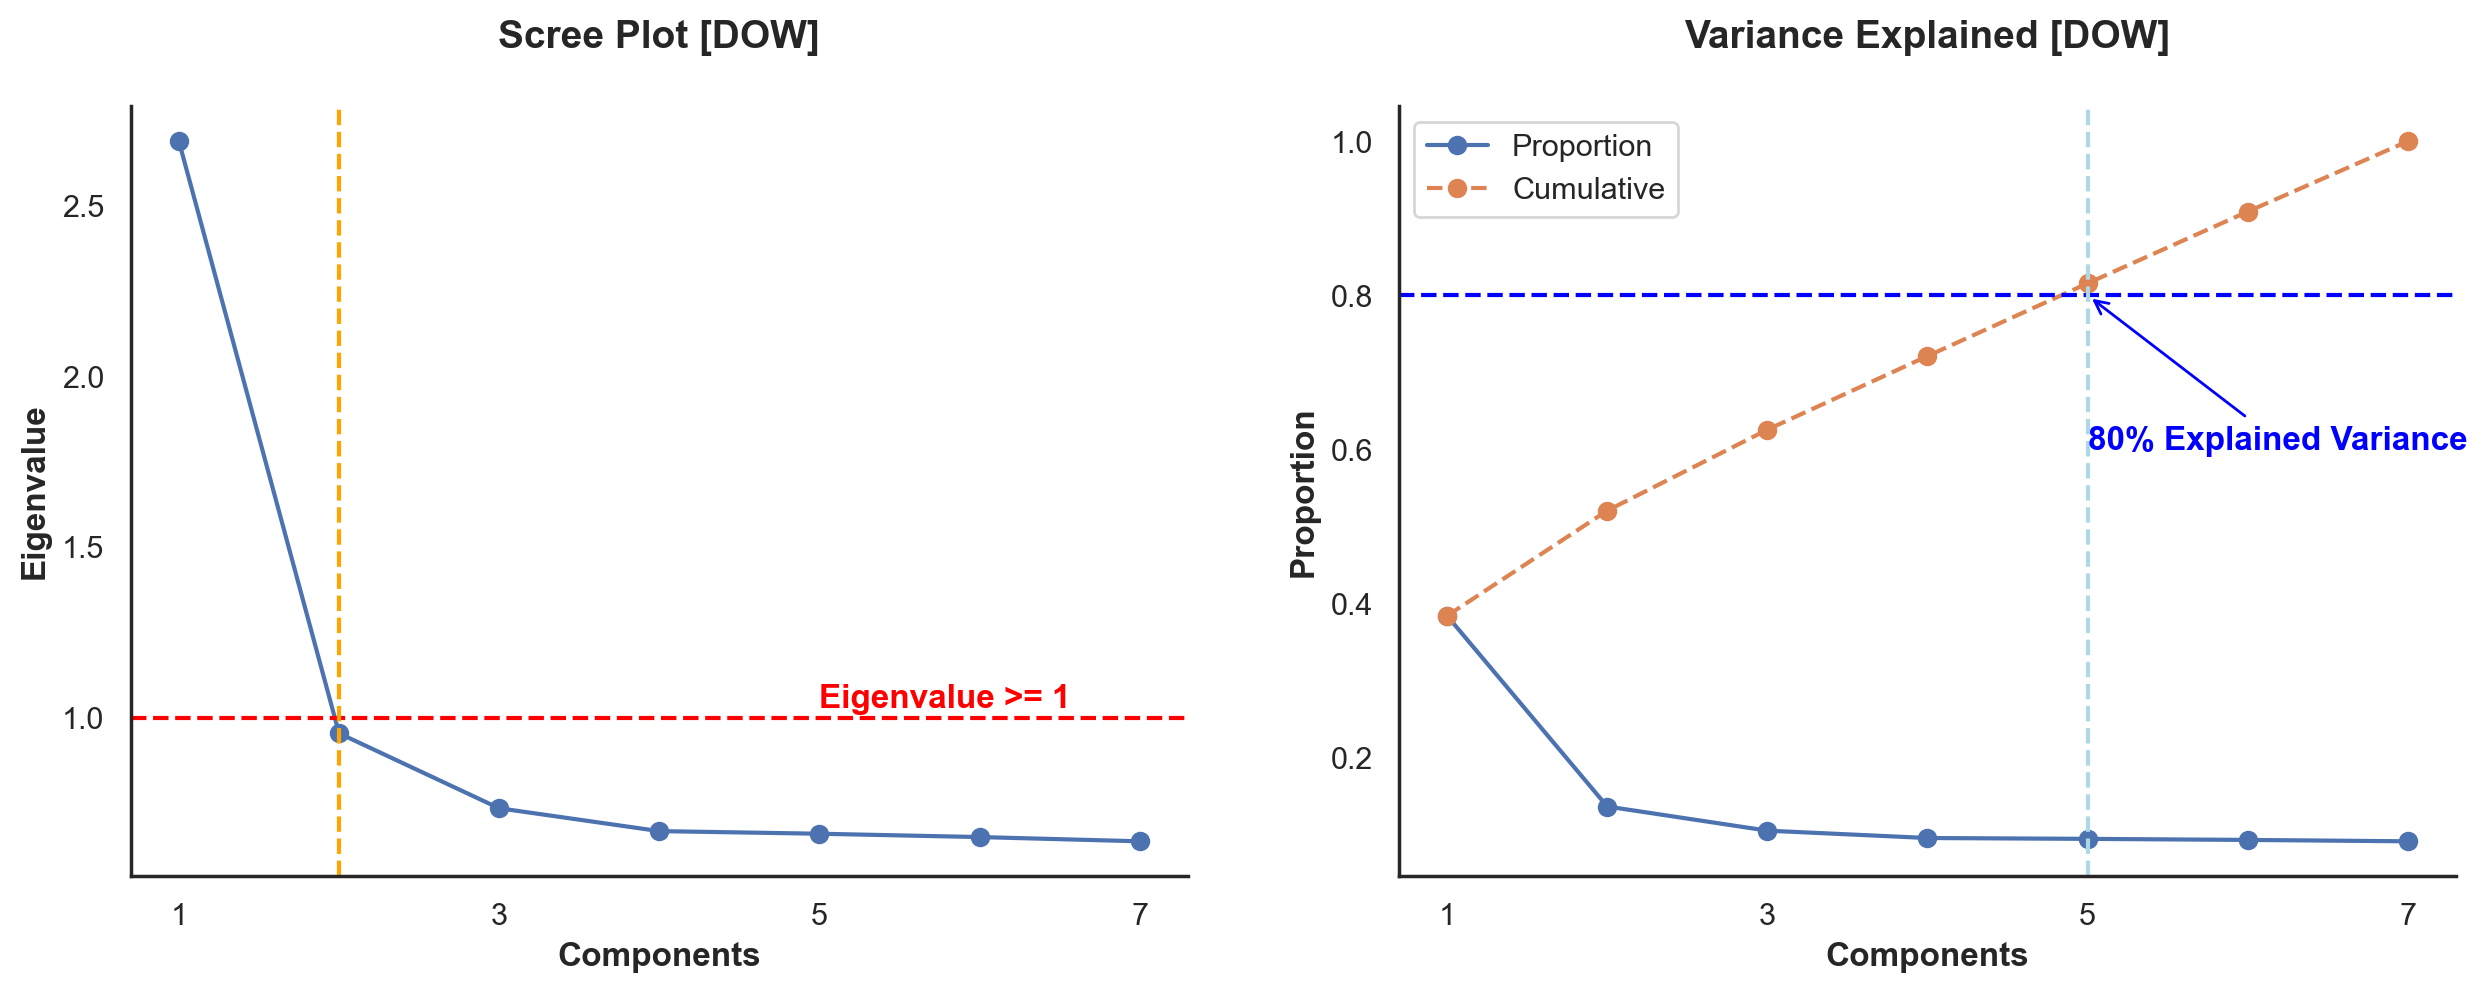

In [216]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots

ax1.plot(explained_variance, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

ax2.plot(explained_variance_ratio, # PLOT THE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, label="Proportion")

ax2.plot(cumulative_explained_variance_ratio, # PLOT THE CUMULATIVE EXPLAINED VARIANCE RATIO
         marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot [DOW]\n", fontsize=14, fontweight="bold")
ax2.set_title("Variance Explained [DOW]\n", fontsize=14, fontweight="bold")
ax1.set_ylabel("Eigenvalue", fontsize=12, fontweight="bold")
ax2.set_ylabel("Proportion", fontsize=12, fontweight="bold")
ax1.set_xlabel("Components", fontsize=12, fontweight="bold")
ax2.set_xlabel("Components", fontsize=12, fontweight="bold")
ax1.set_xticks(range(0, pca_dow.n_components_, 2))
ax1.set_xticklabels(range(1, pca_dow.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca_dow.n_components_, 2))
ax2.set_xticklabels(range(1, pca_dow.n_components_ + 1, 2))

# Add Lines and Annotations
ax1.axhline(1, color="red", linestyle="--")
ax1.annotate("Eigenvalue >= 1", (0, 1), (4, 1.03), fontsize=12, color="red", fontweight="bold")
ax1.axvline(1, color="orange", linestyle="--")

ax2.axhline(0.8, color="blue", linestyle="--")
ax2.annotate("80% Explained Variance", (4, 0.8), (4, 0.6), arrowprops={"arrowstyle": "->", "color": "blue"}, fontsize=12, color="blue", fontweight="bold")
ax2.axvline(4, color="lightblue", linestyle="--")

sns.despine(right=True, top=True)
plt.show()

<div class="alert alert-block alert-info" style="font-size:16px;">

> **1st Rule of Thumb:** Keep $80\%$ of the total variance $\rightarrow$ **`n_components=5`** **[Variance Explained by each PC]**

> **2nd Rule of Thumb:** Keep the components with eigenvalues greater than 1 $\rightarrow$ $PC \;var \ge 1$ $\rightarrow$ **`n_components = 1`**

> **3rd Rule of Thumb:** Keep the components based on the **Scree Plot** $\rightarrow$ **`n_components = 2`**

</div>

In [217]:
# Perform PCA again with the number of principal components you want to retain
pca_dow_final = PCA(n_components=3)
pca_feat_dow_final = pca_dow_final.fit_transform(df_pca[weekdays_cols])
pca_feat_names_dow_final = [f"PC{i}" for i in range(pca_dow_final.n_components_)]

# remember index=df_pca.index
pca_df_dow = pd.DataFrame(pca_feat_dow_final, index=df_pca.index, columns=pca_feat_names_dow_final)  
pca_df_dow

,PC0,PC1,PC2
index,,,
0,-0.85,0.14,-0.70
1,-0.85,0.14,-0.70
2,-0.85,0.14,-0.70
3,-0.86,0.06,-0.46
4,-0.86,0.06,-0.46
...,...,...,...
31883,-1.29,0.39,-0.28
31884,-1.29,0.39,-0.28
31885,-1.29,0.39,-0.28


In [218]:
# Loadings
loadings_dow = pd.concat([df_pca, pca_df_dow], axis=1)[weekdays_cols + pca_feat_names_dow_final].corr().loc[weekdays_cols, pca_feat_names_dow_final]

# Rename index - days of the week (DOW_0 -> Sunday, DOW_1 -> Monday, ..., DOW_6 -> Saturday)
loadings_dow.index = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

In [219]:
# Apply the style to the loadings
loadings_dow.style.map(_color_red_or_green)

,PC0,PC1,PC2
Sunday,0.649737,-0.220289,-0.328973
Monday,0.653105,-0.294649,-0.147805
Tuesday,0.661376,-0.265825,-0.066398
Wednesday,0.656979,-0.204820,0.018828
Thursday,0.611662,-0.005684,0.749962
Friday,0.544797,0.603009,-0.018295
Saturday,0.547401,0.586222,-0.195349


<div class="alert alert-block alert-success" style="font-size:36px;">

> NÃO FAZER !!!
 
</div>

In [220]:
# Dictionary to rename the variables DOW_0, DOW_1, ..., DOW_6 to the days of the week
dow_names = dict(zip(weekdays_cols, ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']))

In [221]:
# Rename the variables DOW_0, DOW_1, ..., DOW_6 to the days of the week
ABCDEats_standard.rename(columns=dow_names, inplace=True)

---

#### **PCA** [`HR`] 

In [222]:
print(hours_cols)

['HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23']


In [223]:
# Use PCA to reduce dimensionality of data
pca_hr = PCA()
pca_feat_hr = pca_hr.fit_transform(df_pca[hours_cols])
pca_feat_hr

array([[-2.89079423e-01, -1.05539173e+00,  2.37136562e-01, ...,
         1.22101489e-01, -6.26966060e-01, -1.17972748e+00],
       [-5.97165788e-01, -4.05415472e-01, -3.24760221e-01, ...,
        -7.40131787e-02,  1.06366506e-02, -3.84851854e-02],
       [-6.32799732e-01, -3.21912712e-01, -4.04646458e-01, ...,
         1.17125591e+00,  3.54777534e-01, -2.71525937e-02],
       ...,
       [-1.49006992e+00, -6.86861307e-02,  1.81577415e-04, ...,
         1.19029991e-02,  6.99645700e-03,  3.98749396e-02],
       [-7.99478111e-01, -7.50153144e-01,  1.24816065e-02, ...,
         5.69903481e-01,  2.02786398e-01, -3.40383676e-02],
       [-7.65843813e-01, -1.03097546e+00, -1.67851177e-01, ...,
        -1.69751566e-01,  4.14305134e-01, -6.14469466e-01]])

In [224]:
# Get PCA output as table

# Get the eigenvalues (explained variance)
explained_variance = pca_hr.explained_variance_

# Get the explained variance ratio
explained_variance_ratio = pca_hr.explained_variance_ratio_

# get the cumulative explained variance ratio
# Hint: use np.cumsum()
cumulative_explained_variance_ratio = np.cumsum(pca_hr.explained_variance_ratio_)

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
    index=range(1, pca_hr.n_components_ + 1)
)

# Apply styling to the DataFrame
pca_results.style.format({
    'Eigenvalue': '{:.2f}',
    'Difference': '{:.2f}',
    'Proportion': '{:.2f}',
    'Cumulative': '{:.2f}'
}).apply(_eigenvalue_highlighter, axis=1)

,Eigenvalue,Difference,Proportion,Cumulative
1,2.62,0.00,0.11,0.11
2,2.07,-0.55,0.09,0.20
3,1.68,-0.39,0.07,0.27
4,1.35,-0.33,0.06,0.32
5,1.22,-0.13,0.05,0.37
6,1.18,-0.04,0.05,0.42
7,1.13,-0.04,0.05,0.47
8,1.03,-0.10,0.04,0.51
9,1.01,-0.03,0.04,0.55
10,0.89,-0.11,0.04,0.59


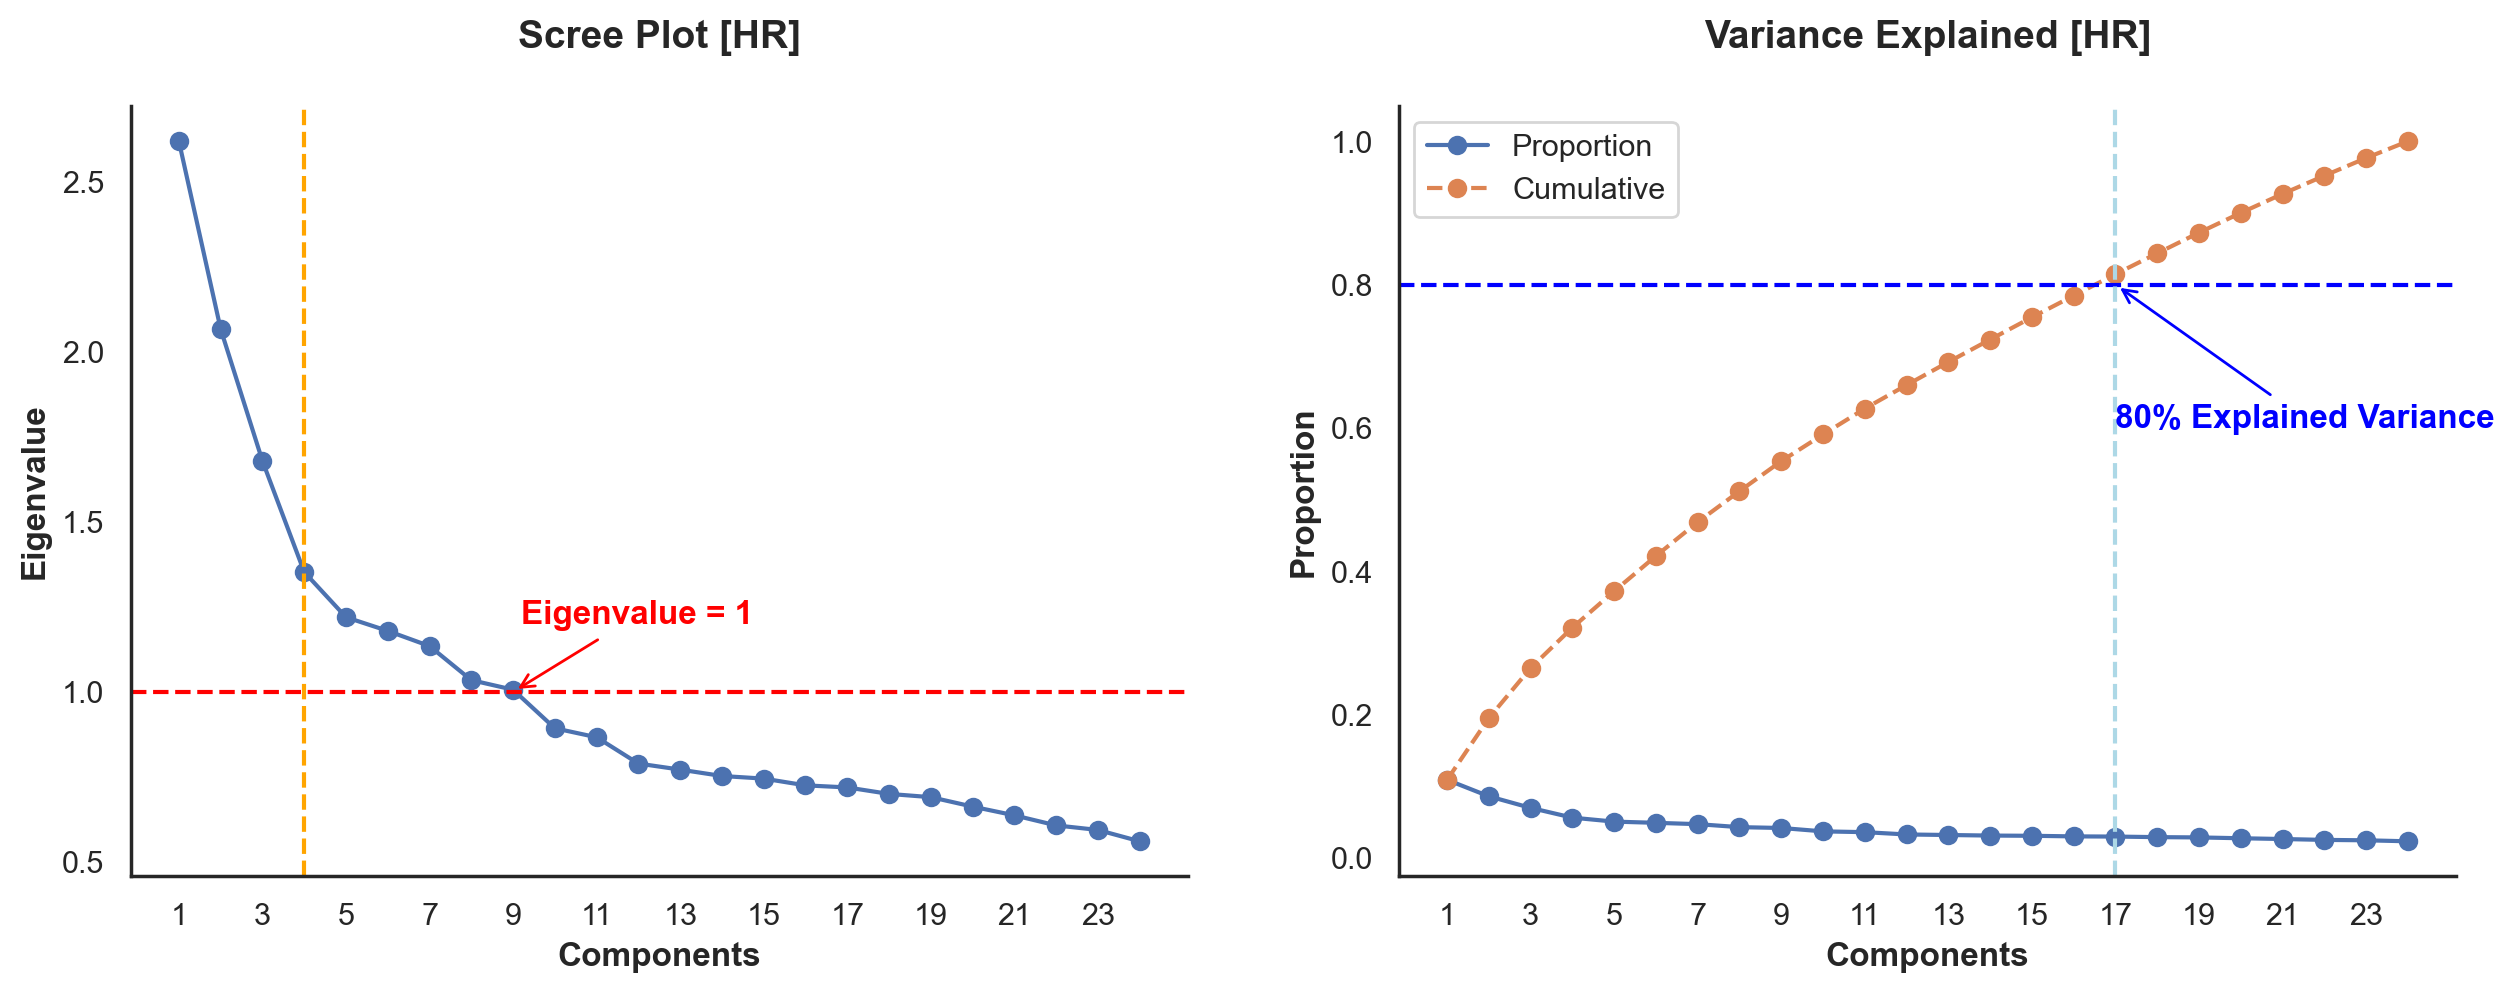

In [225]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots

ax1.plot(explained_variance, # PLOT THE EIGENVALUES (EXPLAINED VARIANCE)
         marker=".", markersize=12)

ax2.plot(explained_variance_ratio, # PLOT THE EXPLAINED VARIANCE RATIO
            marker=".", markersize=12, label="Proportion")

ax2.plot(cumulative_explained_variance_ratio, # PLOT THE CUMULATIVE EXPLAINED VARIANCE RATIO
            marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot [HR]\n", fontsize=14, fontweight="bold")
ax2.set_title("Variance Explained [HR]\n", fontsize=14, fontweight="bold")
ax1.set_ylabel("Eigenvalue", fontsize=12, fontweight="bold")
ax2.set_ylabel("Proportion", fontsize=12, fontweight="bold")
ax1.set_xlabel("Components", fontsize=12, fontweight="bold")
ax2.set_xlabel("Components", fontsize=12, fontweight="bold")
ax1.set_xticks(range(0, pca_hr.n_components_, 2))
ax1.set_xticklabels(range(1, pca_hr.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca_hr.n_components_, 2))
ax2.set_xticklabels(range(1, pca_hr.n_components_ + 1, 2))

# Add Lines and Annotations
ax1.axhline(1, color="red", linestyle="--")
ax1.annotate("Eigenvalue = 1", (8, 1), (8.2, 1.2), arrowprops={"arrowstyle": "->", "color": "red"}, fontsize=12, color="red", fontweight="bold")

# Represent Scree 
ax1.axvline(3, color="orange", linestyle="--")

ax2.axhline(0.8, color="blue", linestyle="--")
ax2.annotate("80% Explained Variance", (16, 0.8), (16, 0.6), arrowprops={"arrowstyle": "->", "color": "blue"}, fontsize=12, color="blue", fontweight="bold")
ax2.axvline(16, color="lightblue", linestyle="--")

sns.despine(right=True, top=True)
plt.show()

<div class="alert alert-block alert-info" style="font-size:16px;">

> **1st Rule of Thumb:** Keep $80\%$ of the total variance $\rightarrow$ **`n_components=5`** **[Variance Explained by each PC]**

> **2nd Rule of Thumb:** Keep the components with eigenvalues greater than 1 $\rightarrow$ $PC \;var \ge 1$ $\rightarrow$ **`n_components = 9`**
 
> **3rd Rule of Thumb:** Keep the components based on the **Scree Plot** $\rightarrow$ **`n_components = 4`**

</div>

In [226]:
# Perform PCA again with the number of principal components you want to retain
pca_hr_final = PCA(n_components=4)
pca_feat_hr_final = pca_hr_final.fit_transform(df_pca[hours_cols])
pca_feat_names_hr_final = [f"PC{i}" for i in range(pca_hr_final.n_components_)]

pca_df_hr = pd.DataFrame(pca_feat_hr_final, index=df_pca.index, columns=pca_feat_names_hr_final)
pca_df_hr

,PC0,PC1,PC2,PC3
index,,,,
0,-0.29,-1.06,0.24,-0.40
1,-0.60,-0.41,-0.32,-0.56
2,-0.63,-0.32,-0.40,-0.50
3,-0.33,-0.58,-0.10,-0.13
4,-0.78,0.10,-0.68,-0.38
...,...,...,...,...
31883,-0.61,-0.75,0.16,-0.35
31884,-0.77,-1.03,-0.17,0.38
31885,-1.49,-0.07,0.00,-0.44


In [227]:
# Loadings
loadings_hr = pd.concat([df_pca, pca_df_hr], axis=1)[hours_cols + pca_feat_names_hr_final].corr().loc[hours_cols, pca_feat_names_hr_final]

In [228]:
# Apply the style to the loadings
loadings_hr.style.map(_color_red_or_green)

,PC0,PC1,PC2,PC3
HR_0,-0.035134,0.315851,0.348847,0.332033
HR_1,-0.102967,0.377006,0.256574,0.306890
HR_2,-0.171052,0.411288,0.149463,0.199881
HR_3,-0.263096,0.394599,0.033426,0.032263
HR_4,-0.261347,0.465525,-0.010080,-0.031096
HR_5,-0.220443,0.439306,-0.065809,-0.103306
HR_6,-0.149799,0.427102,-0.123697,-0.109066
HR_7,-0.044864,0.416786,-0.155101,-0.075721
HR_8,0.107003,0.407955,-0.239983,-0.091562
HR_9,0.171035,0.390339,-0.342702,-0.021668


In [229]:
# ====================== [EXTRA] ======================
# Highlight the maximum absolute value in each row
def highlight_max_abs(s):
    is_max = s.abs() == s.abs().max()
    return ['background-color: #ffeb99' if v else '' for v in is_max]

# Apply the styles
loadings.style.apply(highlight_max_abs, axis=1)

# Highlight the maximum absolute value in each row
loadings_hr.style.apply(highlight_max_abs, axis=1)

,PC0,PC1,PC2,PC3
HR_0,-0.035134,0.315851,0.348847,0.332033
HR_1,-0.102967,0.377006,0.256574,0.306890
HR_2,-0.171052,0.411288,0.149463,0.199881
HR_3,-0.263096,0.394599,0.033426,0.032263
HR_4,-0.261347,0.465525,-0.010080,-0.031096
HR_5,-0.220443,0.439306,-0.065809,-0.103306
HR_6,-0.149799,0.427102,-0.123697,-0.109066
HR_7,-0.044864,0.416786,-0.155101,-0.075721
HR_8,0.107003,0.407955,-0.239983,-0.091562
HR_9,0.171035,0.390339,-0.342702,-0.021668


<div class="alert alert-block alert-warning" style="font-size:36px;">

> Depois de fazer o PCA com 4, 5 e 6 componentes, o melhor é com 4 componentes pq interpretabilidade


In [230]:
# Renaming the PCs
# PC0 -> HR_11 - HR_14 | HR_17 - HR_20     [Lunch & Dinner]
# PC1 -> HR_1 - HR_10                      [Late Night+ Breakfast]
# PC2 -> HR_21 - HR_0                      [Evening]
# PC3 -> HR_15 - HR_16                     [Afternoon Snack]

# Append the PCA features to the dataset
ABCDEats_standard = pd.concat([ABCDEats_standard, pca_df_hr], axis=1)

# Rename the columns
pca_feat_names = ['HR_Lunch_Dinner_PC', 'HR_LateNight_Breakfast_PC', 'HR_Evening_PC', 'HR_AfternoonSnack_PC']
ABCDEats_standard.rename(columns=dict(zip(pca_df_hr.columns, pca_feat_names)), inplace=True)

sum(pca_hr_final.explained_variance_ratio_)

0.3215176396674683

---

# **💾 Save Data** 

<br>

- To finish this notebook and proceed Cluster Analysis, we will save the data to a new file.

In [231]:
# Set 'customer_id' as the index
ABCDEats_standard.set_index('customer_id', inplace=True)
ABCDEats_standard

,customer_region,customer_age,vendor_count,product_count,chain_count,first_order,last_order,last_promo,payment_method,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,HR_0,HR_1,HR_2,HR_3,HR_4,HR_5,HR_6,HR_7,HR_8,HR_9,HR_10,HR_11,HR_12,HR_13,HR_14,HR_15,HR_16,HR_17,HR_18,HR_19,HR_20,HR_21,HR_22,HR_23,order_count,customer_region_buckets,customer_age_group,days_between_orders,days_between_orders_per_order,last_promo_bin,CUI_Total_Amount_Spent,CUI_Most_Spent_Cuisine,CUI_Total_Food_Types,CUI_Avg_Amount_Spent,payment_method_CASH,payment_method_DIGI,last_promo_bin_True,customer_region_2440,customer_region_2490,customer_region_4140,customer_region_4660,customer_region_8370,customer_region_8550,customer_region_8670,customer_region_Unknown,customer_region_buckets_4,customer_region_buckets_8,customer_region_buckets_U,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO PROMO,CUI_Most_Spent_Cuisine_Asian,CUI_Most_Spent_Cuisine_Beverages,CUI_Most_Spent_Cuisine_Cafe,CUI_Most_Spent_Cuisine_Chicken Dishes,CUI_Most_Spent_Cuisine_Chinese,CUI_Most_Spent_Cuisine_Desserts,CUI_Most_Spent_Cuisine_Healthy,CUI_Most_Spent_Cuisine_Indian,CUI_Most_Spent_Cuisine_Italian,CUI_Most_Spent_Cuisine_Japanese,CUI_Most_Spent_Cuisine_Noodle Dishes,CUI_Most_Spent_Cuisine_OTHER,CUI_Most_Spent_Cuisine_Street Food / Snacks,CUI_Most_Spent_Cuisine_Thai,CUI_NOTAsian_Italian_OTHER_NOTSnack_PC,CUI_American_Cafe_Japanese_PC,CUI_Chicken_Chinese_Noodle_PC,CUI_Healthy_NOTAmerican_PC,CUI_Indian_PC,CUI_Japanese_NOTBeverages_PC,CUI_Beverages_Thai_PC,HR_Lunch_Dinner_PC,HR_LateNight_Breakfast_PC,HR_Evening_PC,HR_AfternoonSnack_PC
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,-1.37,-0.40,-0.06,-0.49,-1.19,-2.70,DELIVERY,DIGI,-0.45,-0.46,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,4.78,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,0.52,-0.57,-0.59,-0.61,-0.65,-0.63,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,-0.40,-0.42,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,2.04,-0.33,-0.27,-0.21,-0.17,-0.17,-0.51,2,1,-1.16,-1.01,True,-0.19,Indian,-0.87,0.53,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.15,-0.39,-1.06,0.16,3.59,0.43,-1.25,-0.29,-1.06,0.24,-0.40
5d272b9dcb,8670,-1.51,-0.40,-0.60,-0.20,-1.19,-2.70,DISCOUNT,DIGI,0.80,-0.15,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,0.52,-0.57,-0.59,-0.61,-0.65,-0.63,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,-0.34,0.90,0.76,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,-0.51,8,1,-1.16,-1.01,True,-0.44,American,-0.18,-0.08,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.21,-0.05,-0.55,-0.37,-0.33,-0.17,-0.08,-0.60,-0.41,-0.32,-0.56
f6d1b2ba63,4660,1.53,-0.79,-0.60,-0.20,-1.19,-2.70,DISCOUNT,CASH,0.45,-0.46,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,-0.25,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,0.52,-0.57,-0.59,-0.61,-0.65,-0.63,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0.26,1.24,-0.40,0.76,-0.39,-0.38,-0.37,-0.40,-0.42,-0.43,-0.39,-0.33,-0.27,-0.21,-0.17,-0.17,-0.51,4,2,-1.16,-1.01,True,-0.71,American,-0.87,-0.72,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.11,-0.31,-0.64,-0.19,-0.29,-0.13,-0.05,-0.63,-0.32,-0.40,-0.50
180c632ed8,4660,-0.50,-0.40,-0.42,-0.49,-1.19,-2.65,DELIVERY,DIGI,-0.45,0.20,-0.30,-0.15,-0.24,-0.22,-0.19,-0.19,2.86,-0.31,-0.33,-0.18,-0.34,-0.27,-0.21,-0.57,0.51,-0.59,-0.61,-0.65,-0.63,0.31,-0.17,-0.17,-0.19,-0.24,-0.24,-0.23,-0.21,-0.22,-0

In [232]:
# Save the preprocessed dataset
ABCDEats_standard.to_parquet('data/DM2425_ABCDEats_preprocessed.parquet')

---